In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
from tqdm import trange

from src.SDL_SVP import SDL_SVP
from src.SDL_BCD import SDL_BCD
from src.SDL_SVP import SDL_SVP

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.decomposition import NMF
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import SparseCoder
from sklearn.metrics import roc_curve
from scipy.spatial import ConvexHull

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns
sns.set_theme()
from matplotlib import rc
rc("text", usetex=False)

plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
def compute_accuracy_metrics(Y_test, P_pred, train_data=None, verbose=False):
    # y_test = binary label
    # P_pred = predicted probability for y_test
    # train_data = [X_train, ]
    # compuate various binary classification accuracy metrics
    # Compute classification statistics

    if train_data is not None:
        Y_train, P_train = train_data
        fpr, tpr, thresholds = metrics.roc_curve(Y_train, P_train, pos_label=None)
        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc = round(metrics.auc(fpr, tpr), 4)
        print('threshold from training set used:', mythre)
    else:
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
        mythre = thresholds[np.argmax(tpr - fpr)]
        myauc_test = round(metrics.auc(fpr, tpr), 4)
        print('!!! test AUC:', myauc_test)

    threshold = round(mythre, 4)

    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = round( (tp + tn) / (tp + tn + fp + fn), 4)
    misclassification = 1 - accuracy
    sensitivity = round(tp / (tp + fn), 4)
    specificity = round(tn / (tn + fp), 4)
    precision = round(tp / (tp + fp), 4)
    recall = round(tp / (tp + fn), 4)
    fall_out = round(fp / (fp + tn), 4)
    miss_rate = round(fn / (fn + tp), 4)
    F_score = round(2 * precision * recall / ( precision + recall ), 4)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    #results_dict.update({'Fall_out': fall_out})
    #results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'F_score': F_score})


    if verbose:
        for key in [key for key in results_dict.keys() if key not in ['Y_test', 'Y_pred']]:
            print('% s ===> %.3f' % (key, results_dict.get(key)))
    return results_dict

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def plot_topic_wordcloud(W, idx2word, num_topics=25, num_keywords_in_topic=5, save_name=None, grid_shape = [5,5]):
        # plot the class-conditioanl PMF as wordclouds 
        # W = [(p x r) (words x topic), 1 x r (regression coeff. x topic)]
        # idx2words = list of words used in the vectorization of documents 
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        beta = W[1][0,1:num_topics+1] # first regression coefficient is for the constant term, so omit
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 12), subplot_kw={'xticks': [], 'yticks': []})
        idx_topic = np.argsort(beta)
        idx_topic = np.flip(idx_topic) 
        
        for ax, i in zip(axs.flat, np.arange(W[0].shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx_keyword = np.argsort(W[0][:,idx_topic[i]])
            idx_keyword = np.flip(idx_keyword)   
        
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx_keyword[j]])
                
            Y = " ".join(list_words)
            print('!! Y', Y)
            #stopwords = STOPWORDS
            wc = WordCloud(background_color="white",
                                  colormap = 'Set2',
                                  relative_scaling=0,
                                  width=400,
                                  height=400).generate(Y)
            
            ax.imshow(wc, interpolation="bilinear")
                      #.recolor(color_func=grey_color_func, random_state=3),
                                 
            ax.set_xlabel('%1.2f' % beta[idx_topic[i]], fontsize=15)
            ax.xaxis.set_label_coords(0.5, -0.05)
            
        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')


def coding(X, W, H0,
          r=None,
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5],
          stopping_grad_ratio=0.0001,
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    if H0 is None:
        H0 = np.random.rand(W.shape[1],X.shape[1])

    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation

    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
        # print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H1)**2))
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):

        '''
        Given data matrix X, use alternating least squares to find factors W,H so that
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''

        d, n = X.shape
        r = n_components

        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors
        W = np.random.rand(d,r)
        H = np.random.rand(r,n)
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

    
def plot_topic_wordcloud_nmf(Beta_topic, W, idx2word, num_topics=20, num_keywords_in_topic=5, save_name=None, grid_shape = [4,5]):
        # plot the wordclouds based on NMF->LR results
        # idx2words = list of words used in the vectorization of documents 
        
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 12), 
                                subplot_kw={'xticks': [], 'yticks': []})
        
        ##beta = result['coef'].to_numpy()
        #beta = Beta_topic
        #idx_topic = np.arange(len(beta))
        idx_topic = np.flip(np.argsort(result['coef']))
        print('beta--', result.coef[idx_topic])
        
        for ax, i in zip(axs.flat, np.arange(num_topics)):

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            
            idx_keyword = W[idx_topic[i],:].argsort()[:-num_keywords_in_topic-1:-1]
            list_words = [idx2word[j] for j in idx_keyword]
            Y = " ".join(list_words)
            print(i, list_words, beta[idx_topic[i]])          
            
            wc = WordCloud(background_color="black",
                           relative_scaling=0,
                           width=400,
                           height=400).generate(Y)
            
            ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
                      interpolation="bilinear")
                
            ax.set_xlabel('%1.2f' % beta[idx_topic[i]], fontsize=15)
            ax.xaxis.set_label_coords(0.5, -0.05)
    
        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')
            

In [3]:
path = "Data/fake_job_postings.csv"
data = pd.read_csv(path, delimiter=',')
Y = data['fraudulent']
print(sum(Y)/len(Y)) # prop : 5%

path = "Data/results_data_description2.csv"
text = pd.read_csv(path, delimiter = ',')

others = pd.read_csv("Data/fake_job_postings_v9.csv", delimiter=',')
covariate = others.get(others.keys()[1:73]) # covariates 

total_variable = list(covariate.keys()) + list(text.keys()) # variable name

#X = np.hstack((covariate, text))
print(Y.shape)

0.04843400447427293
(17880,)


In [4]:
Y = np.asarray(Y) # indicator of fraud postings
print('Y.shape', Y.shape)

text = text.values
text = text - np.min(text) # word frequency array
print('text.shape', text.shape) # words x docs

covariate = covariate.values
covariate = covariate - np.min(covariate) 
print('covariate.shape', covariate.shape) 

Y.shape (17880,)
text.shape (17880, 2498)
covariate.shape (17880, 72)


In [5]:
np.random.seed(1)
Y_train, Y_test, text_train, text_test, covariate_train, covariate_test = train_test_split(Y, text, covariate, 
                                                                                           test_size = 0.2)
print('ratio of fraud postings in train set:', np.sum(Y_train)/Y_train.shape)
print('ratio of fraud postings in test set:', np.sum(Y_test)/Y_test.shape)

text_train, text_test = text_train.T, text_test.T
covariate_train, covariate_test = covariate_train.T, covariate_test.T
Y_train, Y_test = Y_train[np.newaxis,:], Y_test[np.newaxis,:]

X_train = np.vstack([covariate_train, text_train])
X_test = np.vstack([covariate_test, text_test])

print(Y_train.shape)
print(X_train.shape)
print(text_train.shape)
print(covariate_train.shape)

ratio of fraud postings in train set: [0.0498462]
ratio of fraud postings in test set: [0.04278523]
(1, 14304)
(2570, 14304)
(2498, 14304)
(72, 14304)


# Without covariate

In [6]:
np.random.seed(1)
Y_train, Y_test, text_train, text_test, covariate_train, covariate_test = train_test_split(Y, text, covariate, 
                                                                                           test_size = 0.2)
print('ratio of fraud postings in train set:', np.sum(Y_train)/Y_train.shape)
print('ratio of fraud postings in test set:', np.sum(Y_test)/Y_test.shape)

text_train, text_test = text_train.T, text_test.T
covariate_train, covariate_test = covariate_train.T, covariate_test.T
Y_train, Y_test = Y_train[np.newaxis,:], Y_test[np.newaxis,:]

X_train = text_train
X_test = text_test

print(Y_train.shape)
print(X_train.shape)
print(text_train.shape)
print(covariate_train.shape)

ratio of fraud postings in train set: [0.0498462]
ratio of fraud postings in test set: [0.04278523]
(1, 14304)
(2498, 14304)
(2498, 14304)
(72, 14304)


threshold from training set used: 0.07943784912698805
AUC ===> 0.965
Opt_threshold ===> 0.079
Accuracy ===> 0.913
Sensitivity ===> 0.784
Specificity ===> 0.919
Precision ===> 0.301
F_score ===> 0.436
                word      coef
1433           money  3.320977
707             earn  3.314975
1299            link  3.170778
761      engineering  3.002885
2072           skill  2.609279
780            entry  2.498290
126           answer  2.468726
971              gas  2.372947
57    administrative  2.251751
181        assistant  2.224851
2438             web -1.661945
1361       marketing -1.761287
1950            role -1.785119
1014            grow -1.805286
235             base -1.984187
1942           right -2.084742
2370            user -2.143061
2440         website -2.223821
387           client -2.521187
2240            team -2.650815


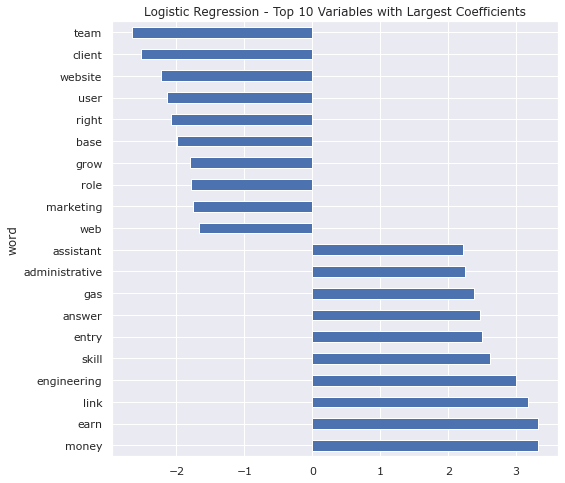

In [7]:
###### LR ######

results_dict_list = []

clf = LogisticRegression(random_state=0).fit(text_train.T, Y_train[0,:])
P_train = clf.predict_proba(text_train.T)
P_pred = clf.predict_proba(text_test.T)
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)

results.update({'method': 'LR'})
results.update({'xi': None})
results.update({'beta': None})
results.update({'Relative_reconstruction_loss (test)': 1})
results.update({'Accuracy': results.get('Accuracy')})
results_dict_list.append(results.copy())

mybeta = clf.coef_
result = pd.DataFrame({"word" : total_variable[72:], "coef": mybeta[0]})
result1 = result.sort_values(by = 'coef', ascending = False).head(10)
result0 = result.sort_values(by = 'coef', ascending = False).tail(10)
result = pd.concat([result1, result0])
print(result)

plt.rcParams['font.sans-serif'] = ['Verdana']

fig, ax = plt.subplots(1,1,figsize=(8,8))
result.plot.barh(ax = ax, x = 'word', y = 'coef', legend = None)
ax.set_title("Logistic Regression - Top 10 Variables with Largest Coefficients")
plt.show()
#plt.savefig("Output_files/Logistic/bargraph of top 10 beta coefficients - " + covariate + "_" + str(i) + ".pdf", bbox_inches='tight')

100%|██████████| 200/200 [01:07<00:00,  2.95it/s]
/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


threshold from training set used: 0.04722045183487421
AUC ===> 0.778
Opt_threshold ===> 0.047
Accuracy ===> 0.662
Sensitivity ===> 0.732
Specificity ===> 0.659
Precision ===> 0.088
F_score ===> 0.157
!! Y test campaign real engineer hotel software company work product manager
!! Y customer service support require provide equipment include duty quality maintain
!! Y team work experience software look developer environment join want skill
!! Y team test work software product person grow customer new look
!! Y business data technology use manager bi experience support analyst platform
!! Y project development technical test software application experience requirement management engineering
!! Y care patient home health nurse provide medical staff support assist
!! Y company tidewater finance position opportunity work employee time benefit hour
!! Y sale customer product account service representative new business relationship sell
!! Y candidate web work role career experience look positi

IndexError: index 24 is out of bounds for axis 0 with size 24

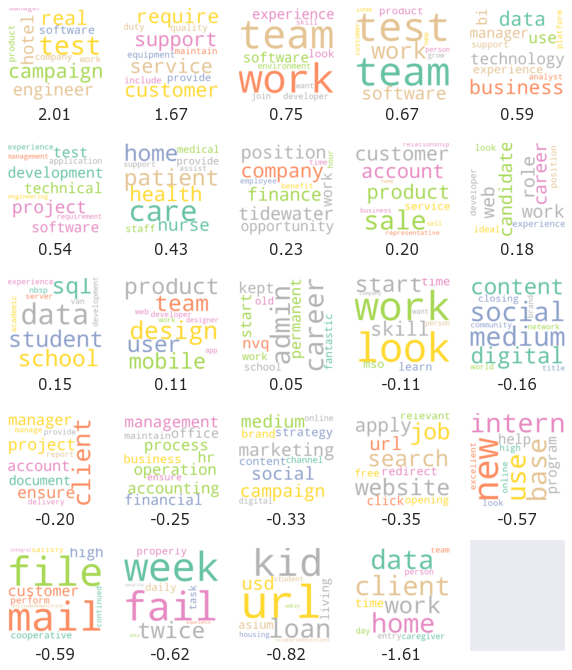

In [8]:
# MF -> LR

r = 25
iteration = 200

W, H = ALS(text_train,
           n_components = r, # number of columns in the dictionary matrix W
           n_iter=iteration,
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=False,
           subsample_ratio = 1)

new_train = W.T @ text_train
new_test = W.T @ text_test

clf = LogisticRegression(random_state=0).fit(new_train.T, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train.T) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test.T) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

W0 = [W, clf.coef_]
plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

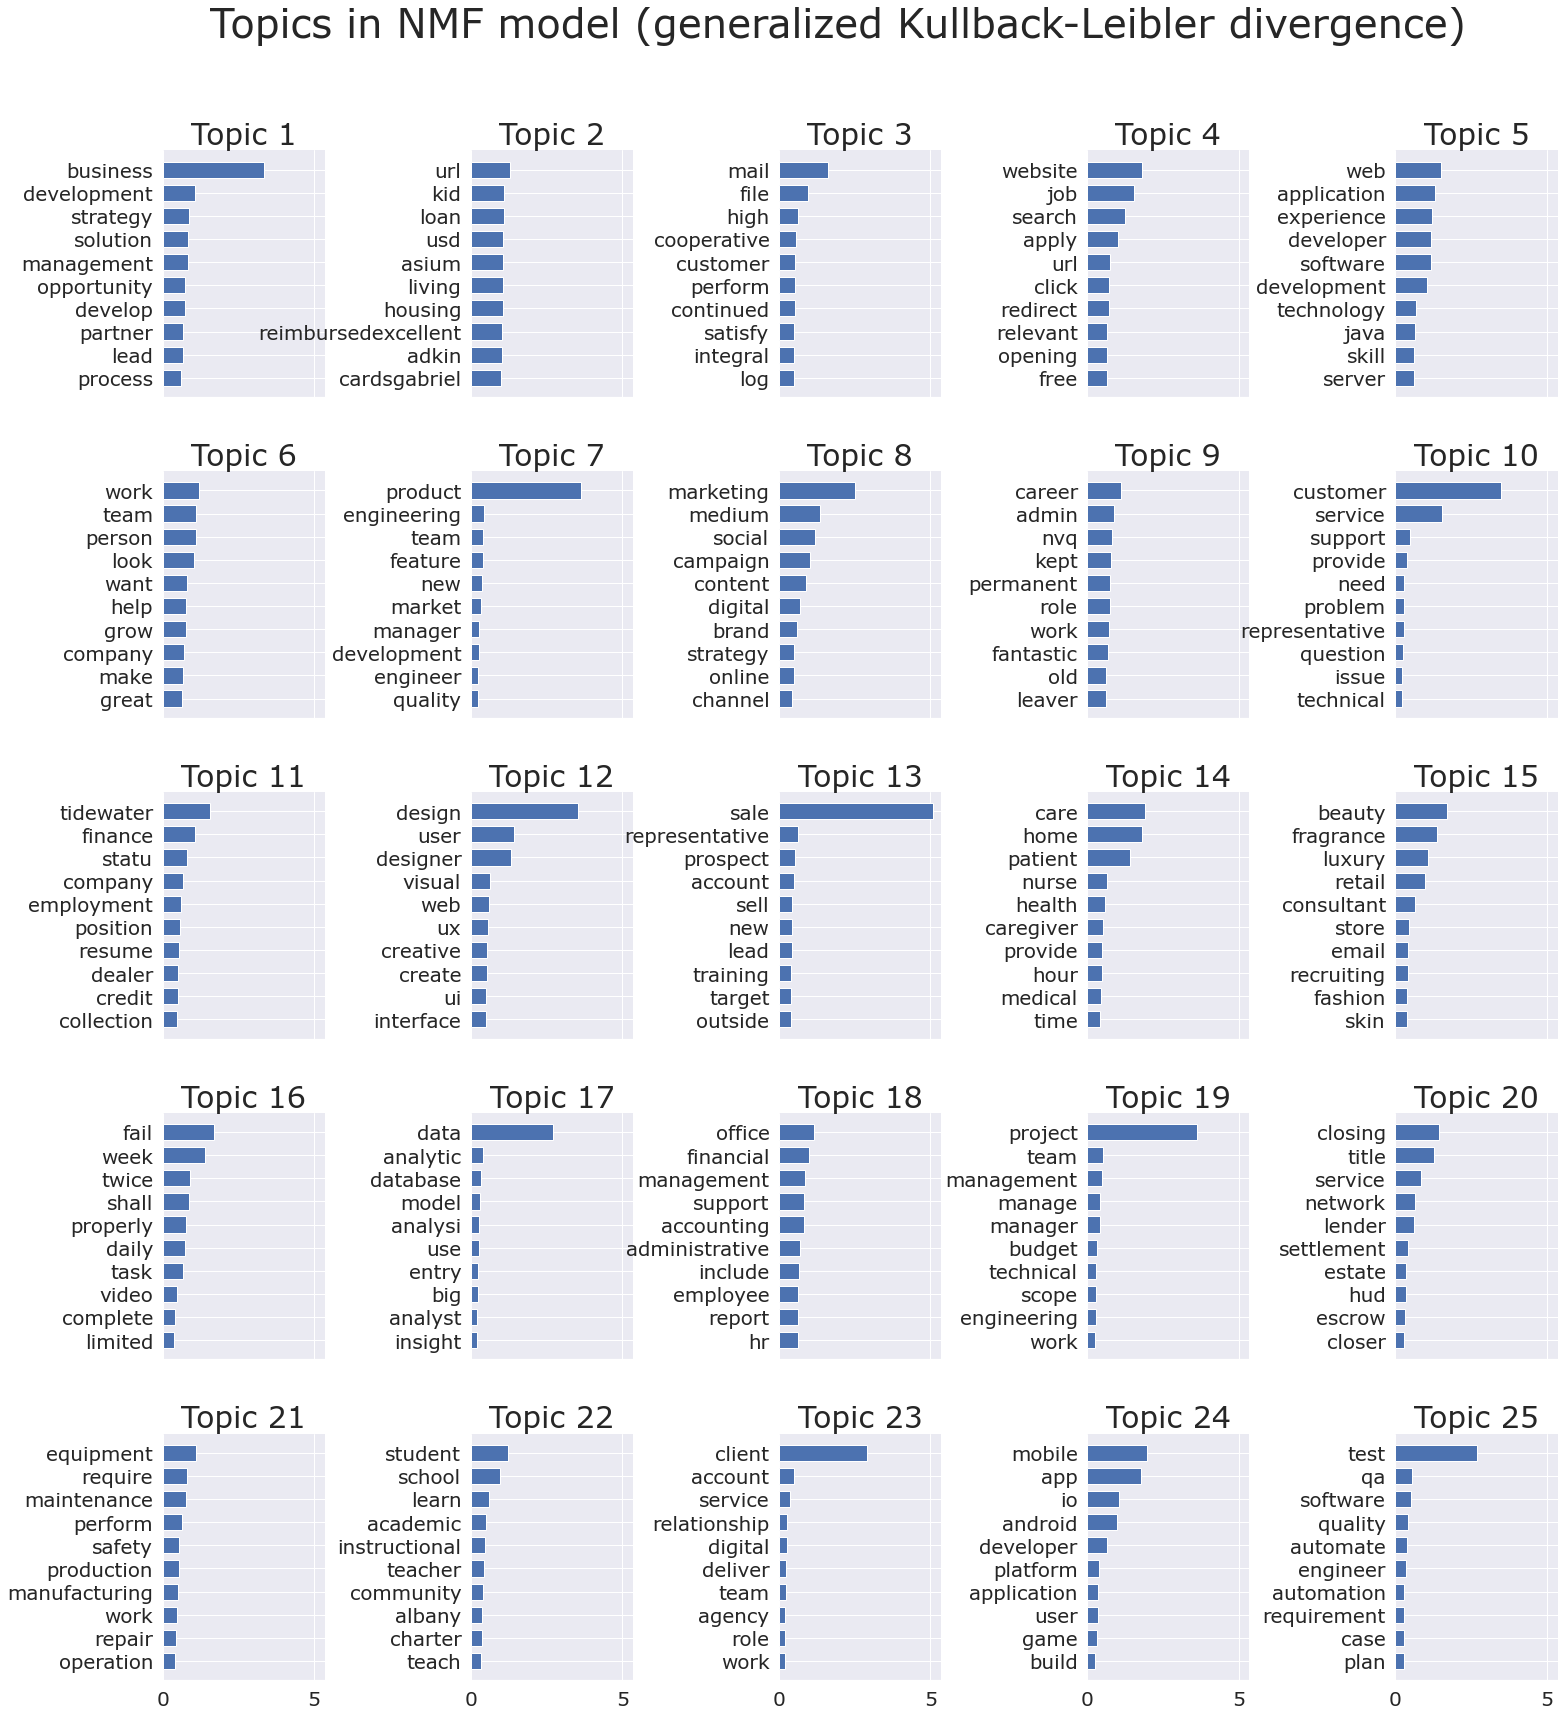

In [37]:
from sklearn.decomposition import NMF

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 5, figsize=(25, 25), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


nmf = NMF(n_components=25, random_state=1).fit(text_train.T)
plot_top_words(
    nmf,
    total_variable[72:],
    10,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)    

In [98]:
# SDL - filter_based

xi_list = [1]
iter_avg = 1
beta = 0.5
iteration = 100
r = 10

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)
        #print(i, results_dict_new.get('Accuracy'), results_dict_new.get('F_score'))
        #results_dict_new.update({'method': 'SDL-filt'})
        #results_dict_new.update({'beta': beta})
        #results_dict_list.append(results_dict_new.copy())
        # print('Beta_learned', results_dict.get('loading')[1])


  0%|          | 0/100 [00:00<?, ?it/s]

initial loading beta [[ 0.41144744 -0.76771425  0.55868784 -0.8060806   0.63080117  0.4581196
  -0.85039615 -0.26178686  0.0441148  -0.18252747 -0.58841138]]


 19%|█▉        | 19/100 [00:33<02:23,  1.77s/it]


KeyboardInterrupt: 

(2498, 14304)

In [94]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 5,
 'loading': [array([[2.38955726e-07, 7.74631555e-07, 1.42902053e-04, 0.00000000e+00,
          0.00000000e+00],
         [9.03968376e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.17379702e-03],
         [6.03089548e-04, 1.04454338e-04, 7.52789273e-03, 0.00000000e+00,
          8.62306533e-03],
         ...,
         [1.22560391e-06, 1.09877074e-05, 3.21646160e-04, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 2.25507057e-05, 3.40591162e-04, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 2.66886179e-05, 3.23535350e-04, 0.00000000e+00,
          0.00000000e+00]]),
  array([[-4.35490353, -1.08274291, -1.2003212 , -7.21014373, 23.2741323 ,
          -1.32704985]])],
 'code': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ...

In [90]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 10,
 'loading': [array([[1.76034939e-03, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.83528138e-03, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.48427609e-03, 0.00000000e+00, 2.25561862e-03, ...,
          1.89103621e-03, 0.00000000e+00, 3.63983871e-03],
         ...,
         [3.14352154e-03, 0.00000000e+00, 0.00000000e+00, ...,
          1.64272871e-05, 6.00766289e-06, 0.00000000e+00],
         [3.34351782e-03, 0.00000000e+00, 1.90425616e-05, ...,
          8.76659040e-06, 1.50101491e-05, 0.00000000e+00],
         [3.78255562e-03, 0.00000000e+00, 1.27806739e-06, ...,
          0.00000000e+00, 1.72254596e-05, 0.00000000e+00]]),
  array([[ -3.411769  , -15.05308972,  21.33408259,  -0.42941477,
           -0.50466416,  -0.7987561 ,  -0.57448737,   0.16522

!! Y earn engineering money entry link gas skill administrative oil answer
!! Y earn money engineering entry administrative time link skill gas home
!! Y earn money engineering entry administrative link skill gas oil answer
!! Y project equipment document perform control maintenance process require schedule engineering
!! Y home care patient data time work hour health nurse seek
!! Y service customer product beauty need skill fragrance able work position
!! Y customer ensure delivery timely service manner responsible daily location account
!! Y business job operation process support management account program require provide
!! Y tidewater finance statu company employment include collection resume dealer credit
!! Y career admin work nvq role kept permanent fantastic candidate position
!! Y file mail neededenter guidelinesadhere backfill fold detailparticipate insert equipmentshipping receivinghandle
!! Y software test data application technical engineer development technology support 

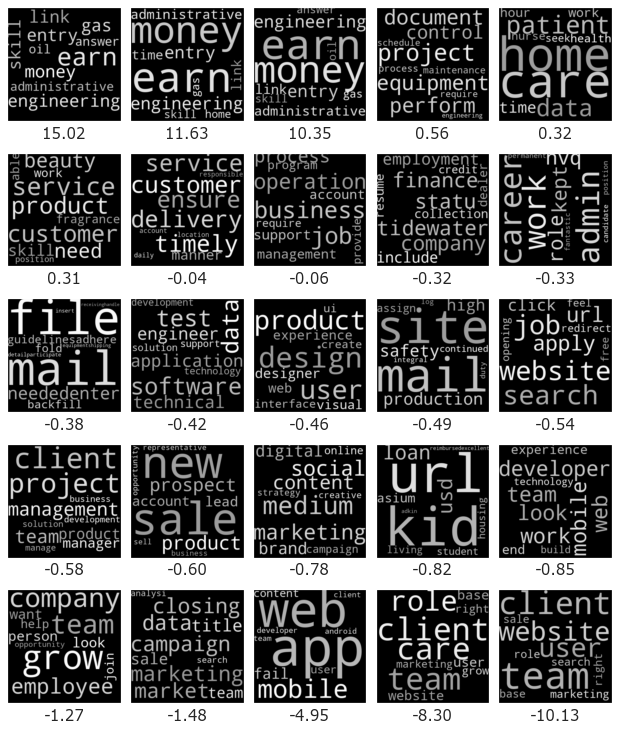

In [87]:
W0 = results_dict_new.get('loading')
plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [121]:
r = 10
xi = 10
iteration = 100

# SDL_SVP_filter
data_scale=10
for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SDL_SVP_class = SDL_SVP(X=[X_train/data_scale, Y_train],  # data, label
                                X_test=[X_test/data_scale, Y_test],
                                #X_auxiliary = None,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SDL_SVP_class.fit(iter=iteration, subsample_size=None,
                                                beta = 0,
                                                nu = 2,
                                                search_radius_const=0.05,
                                                update_nuance_param=False,
                                                SDL_option = 'filter',
                                                prediction_method_list = ['filter'],
                                                fine_tune_beta = False,
                                                if_compute_recons_error=True, if_validate=False)
        results_dict_new.update({'method': 'SDL-conv-filt'})
        results_dict_new.update({'beta': None})
        results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (filter)')})
        results_dict_new.update({'F_score': results_dict_new.get('F_score (filter)')})
        results_dict_list.append(results_dict_new.copy())

  0%|          | 0/100 [00:00<?, ?it/s]

initial loading beta [[ 0.32975231  0.31945595 -0.05823155  0.26993633  0.29833548 -0.46052711
   0.48711009 -0.72994404  0.35066141 -0.03754088  0.91840924]]


  1%|          | 1/100 [00:04<07:35,  4.60s/it]

*** rel_error_data train 1387848.3854613076
--- Training --- [threshold, AUC] =  [0.0, 0.437]
--- Iteration 0: Training loss --- [Data, Label, Total] = [197672777.503356.3, 322470.705153.3, 197995248.208509.3]
error_time (1, 3)


 11%|█         | 11/100 [00:24<03:37,  2.44s/it]

*** rel_error_data train 168730.7926162363
--- Training --- [threshold, AUC] =  [0.0, 0.438]
--- Iteration 10: Training loss --- [Data, Label, Total] = [24032513.044073.3, 68245.568615.3, 24100758.612688.3]
error_time (2, 3)


 21%|██        | 21/100 [00:44<03:09,  2.40s/it]

*** rel_error_data train 20514.540972191902
--- Training --- [threshold, AUC] =  [0.0, 0.452]
--- Iteration 20: Training loss --- [Data, Label, Total] = [2921908.715433.3, 324035.501363.3, 3245944.216797.3]
error_time (3, 3)


 31%|███       | 31/100 [01:03<02:45,  2.40s/it]

*** rel_error_data train 2494.912827916979
--- Training --- [threshold, AUC] =  [0.0, 0.496]
--- Iteration 30: Training loss --- [Data, Label, Total] = [355353.188064.3, 69771.833994.3, 425125.022058.3]
error_time (4, 3)


 41%|████      | 41/100 [01:23<02:23,  2.43s/it]

*** rel_error_data train 304.0941678257578
--- Training --- [threshold, AUC] =  [0.0, 0.674]
--- Iteration 40: Training loss --- [Data, Label, Total] = [43312.467995.3, 325544.217002.3, 368856.684996.3]
error_time (5, 3)


 51%|█████     | 51/100 [01:43<02:00,  2.46s/it]

*** rel_error_data train 37.79840023534269
--- Training --- [threshold, AUC] =  [0.0, 0.704]
--- Iteration 50: Training loss --- [Data, Label, Total] = [5383.667869.3, 71207.280612.3, 76590.948481.3]
error_time (6, 3)


 61%|██████    | 61/100 [02:04<01:34,  2.43s/it]

*** rel_error_data train 5.414672368054206
--- Training --- [threshold, AUC] =  [0.0, 0.807]
--- Iteration 60: Training loss --- [Data, Label, Total] = [771.217762.3, 326581.722971.3, 327352.940734.3]
error_time (7, 3)


 71%|███████   | 71/100 [02:24<01:09,  2.40s/it]

*** rel_error_data train 1.437194821484959
--- Training --- [threshold, AUC] =  [0.0, 0.799]
--- Iteration 70: Training loss --- [Data, Label, Total] = [204.701245.3, 72242.318116.3, 72447.019361.3]
error_time (8, 3)


 81%|████████  | 81/100 [02:44<00:46,  2.42s/it]

*** rel_error_data train 0.9218647780806795
--- Training --- [threshold, AUC] =  [0.0, 0.847]
--- Iteration 80: Training loss --- [Data, Label, Total] = [131.302218.3, 325817.520618.3, 325948.822836.3]
error_time (9, 3)


 91%|█████████ | 91/100 [03:03<00:21,  2.41s/it]

*** rel_error_data train 0.8528988721420677
--- Training --- [threshold, AUC] =  [0.0, 0.838]
--- Iteration 90: Training loss --- [Data, Label, Total] = [121.479328.3, 71478.063302.3, 71599.542629.3]
error_time (10, 3)


100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.0, 0.864]
!!! ACC_list [0.7953020134228188]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.000, 0.858, 0.795, 0.917]


!! Y earn home administrative hour entry skill cash time oil money
!! Y url kid loan usd asium living housing student adkin cardsgabriel
!! Y marketing medium social campaign digital mail content brand online website
!! Y sale design web developer designer client application project account mail
!! Y customer product test help app software engineer engineering service job
!! Y project marketing client management manage ensure strategy process sale develop
!! Y sale customer website job search account marketing service apply representative
!! Y mail customer file service perform high assign cooperative continued log
!! Y website job search apply click redirect feel relevant main opening
!! Y team customer work sale client product business service company marketing


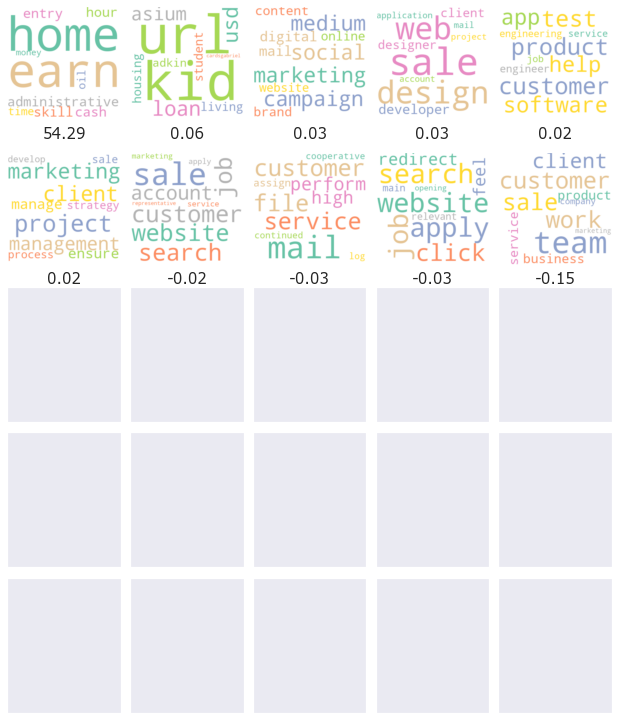

In [126]:
plot_topic_wordcloud(results_dict_new.get('loading'), total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [127]:
data_scale=10
prediction_method_list = ['naive']
for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        print("SDL-conv-feat..")
        data_scale=500
        SDL_SVP_class = SDL_SVP(X=[X_train/data_scale, Y_train],  # data, label
                                X_test=[X_test/data_scale, Y_test],
                                #X_auxiliary = covariate_train/data_scale,
                                #X_test_aux = covariate_test/data_scale,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0]) # L2 regularizer for code H, dictionary W[0], reg param W[1]


        results_dict_new = SDL_SVP_class.fit(iter=iteration, subsample_size=None,
                                            beta = 0,
                                            nu = 2,
                                            search_radius_const=0.01,
                                            update_nuance_param=False,
                                            SDL_option = 'feature',
                                            #prediction_method_list = ['naive', 'exhaustive'],
                                            prediction_method_list = prediction_method_list,
                                            if_compute_recons_error=True, if_validate=False)

        for pred_type in prediction_method_list:
            results_dict_new.update({'method': 'SDL-conv-feat ({})'.format(str(pred_type))})
            results_dict_new.update({'beta': None})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy ({})'.format(str(pred_type)))})
            results_dict_new.update({'F_score': results_dict_new.get('F_score ({})'.format(str(pred_type)))})
            results_dict_new.update({'time_error': results_dict_new.get('time_error')})
            results_dict_list.append(results_dict_new.copy())



SDL-conv-feat..


  0%|          | 0/100 [00:00<?, ?it/s]

initial loading beta [[-9.02641196e-01  4.01715321e-01  3.39402423e-01  6.89897786e-01
  -1.47469585e-01  1.67160379e-01 -4.83625929e-01  5.96569848e-01
  -1.73931660e-03 -4.81855076e-02 -3.45721164e-04]]


  1%|          | 1/100 [00:04<07:07,  4.32s/it]

*** rel_error_data train 4074815901.2625217
--- Training --- [threshold, AUC] =  [0.0, 0.482]
--- Iteration 0: Training loss --- [Data, Label, Total] = [232152210.704102.3, 42508.064160.3, 232194718.768262.3]
error_time (1, 3)


 11%|█         | 11/100 [00:24<03:41,  2.49s/it]

*** rel_error_data train 2720379579.3573623
--- Training --- [threshold, AUC] =  [0.599, 0.483]
--- Iteration 10: Training loss --- [Data, Label, Total] = [154986666.540305.3, 15475.883909.3, 155002142.424214.3]
error_time (2, 3)


 21%|██        | 21/100 [00:43<03:05,  2.35s/it]

*** rel_error_data train 1816147093.5825877
--- Training --- [threshold, AUC] =  [0.0, 0.484]
--- Iteration 20: Training loss --- [Data, Label, Total] = [103470334.109670.3, 16412.531521.3, 103486746.641190.3]
error_time (3, 3)


 31%|███       | 31/100 [01:02<02:41,  2.34s/it]

*** rel_error_data train 1212474277.7057908
--- Training --- [threshold, AUC] =  [0.0, 0.485]
--- Iteration 30: Training loss --- [Data, Label, Total] = [69077619.900336.3, 53382.372279.3, 69131002.272615.3]
error_time (4, 3)


 41%|████      | 41/100 [01:22<02:23,  2.43s/it]

*** rel_error_data train 809457493.4218116
--- Training --- [threshold, AUC] =  [0.021, 0.487]
--- Iteration 40: Training loss --- [Data, Label, Total] = [46116769.719744.3, 2967.360751.3, 46119737.080495.3]
error_time (5, 3)


 51%|█████     | 51/100 [01:42<01:58,  2.43s/it]

*** rel_error_data train 540400275.3750694
--- Training --- [threshold, AUC] =  [0.0, 0.49]
--- Iteration 50: Training loss --- [Data, Label, Total] = [30787923.094773.3, 5883.890856.3, 30793806.985629.3]
error_time (6, 3)


 61%|██████    | 61/100 [02:02<01:36,  2.48s/it]

*** rel_error_data train 360775531.59871894
--- Training --- [threshold, AUC] =  [0.0, 0.495]
--- Iteration 60: Training loss --- [Data, Label, Total] = [20554262.881580.3, 14498.957595.3, 20568761.839175.3]
error_time (7, 3)


 71%|███████   | 71/100 [02:23<01:11,  2.47s/it]

*** rel_error_data train 240856620.5161534
--- Training --- [threshold, AUC] =  [0.0, 0.501]
--- Iteration 70: Training loss --- [Data, Label, Total] = [13722189.730883.3, 31855.379639.3, 13754045.110522.3]
error_time (8, 3)


 81%|████████  | 81/100 [02:43<00:45,  2.38s/it]

*** rel_error_data train 160797799.2400168
--- Training --- [threshold, AUC] =  [0.0, 0.51]
--- Iteration 80: Training loss --- [Data, Label, Total] = [9161043.216298.3, 53455.297470.3, 9214498.513768.3]
error_time (9, 3)


 91%|█████████ | 91/100 [03:02<00:21,  2.40s/it]

*** rel_error_data train 107349891.6244693
--- Training --- [threshold, AUC] =  [0.019, 0.523]
--- Iteration 90: Training loss --- [Data, Label, Total] = [6115985.424457.3, 2979.743352.3, 6118965.167809.3]
error_time (10, 3)


100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [1.001, 0.481]
!!! ACC_list [0.9572147651006712]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.001, 0.495, 0.957, 0.997]


/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:908: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


!! Y competition past active core offline shot spend geographic milestone guru
!! Y chance leaver associate view cros reference paper propose accept day
!! Y procedure thrive reading efficiency fl rare defect central producer generation
!! Y nh receptionist hardware include la hottest bring additionally lifecycle demeanor
!! Y prepared total developmental consider ecommerce packaging cm expectation safety rest
!! Y informal frame flat remediation santum task colleague history member fit
!! Y utmost fully respect diverse row extra excel sub establish kpus
!! Y programmer renewal root continuou productive broad food aw payment oral
!! Y prioritization eat va layout logistic target assure strongly diploma tag
!! Y involvement sale vary advertising linux corporation trust lender echo verbally


'\nmybeta = results_dict_new.get(\'loading\')[1]\ndic_list = []\nfor i in np.arange(10):\n    i = i+1\n    word = \'Topic\' + str(i)\n    dic_list.append(word)\ndic_list\n\nresult = pd.DataFrame({"word" : dic_list, "coef": mybeta[0][1:]})\nresult = result.sort_values(by = \'coef\', ascending = False)\nprint(result)\n# 0,1\n\nW = results_dict_new.get(\'loading\')[0]\nW = W[:,[0,1]]\nW2 = results_dict_new.get(\'loading\')[1][:,[0,1]]\nW2 = np.asarray([list([1]) + list(W2[0])])\n\nplot_topic_wordcloud(results_dict_new.get(\'loading\'), total_variable[72:], num_topics=10, num_keywords_in_topic=10, save_name=None, grid_shape = [2,5])\n#plot_topic_wordcloud([W, W2], total_variable[72:], num_topics=2, num_keywords_in_topic=10, save_name=None, grid_shape = [1,2])\n'

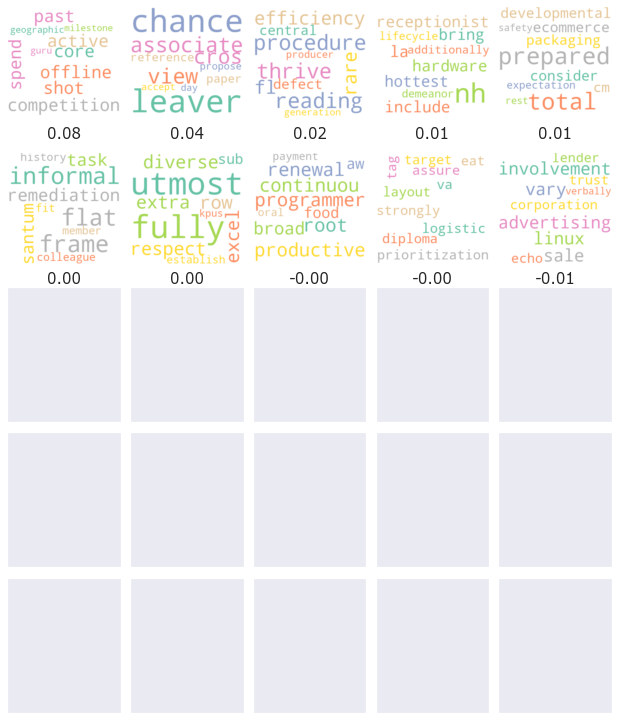

In [128]:
plot_topic_wordcloud(results_dict_new.get('loading'), total_variable[72:], num_topics=10, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])
'''
mybeta = results_dict_new.get('loading')[1]
dic_list = []
for i in np.arange(10):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": mybeta[0][1:]})
result = result.sort_values(by = 'coef', ascending = False)
print(result)
# 0,1

W = results_dict_new.get('loading')[0]
W = W[:,[0,1]]
W2 = results_dict_new.get('loading')[1][:,[0,1]]
W2 = np.asarray([list([1]) + list(W2[0])])

plot_topic_wordcloud(results_dict_new.get('loading'), total_variable[72:], num_topics=10, num_keywords_in_topic=10, save_name=None, grid_shape = [2,5])
#plot_topic_wordcloud([W, W2], total_variable[72:], num_topics=2, num_keywords_in_topic=10, save_name=None, grid_shape = [1,2])
'''

!! Y home earn entry skill position administrative time type hour perform
!! Y url kid loan usd asium living housing reimbursedexcellent cardsgabriel adkin
!! Y marketing medium social campaign content mail sale digital website brand
!! Y customer product sale software test service representative engineer new engineering
!! Y data project marketing design career admin nvq kept candidate permanent
!! Y sale marketing customer account service client opportunity position relationship website
!! Y work career look start want position care nvq admin permanent
!! Y website job search apply redirect click relevant feel main opening
!! Y mail customer file service perform high cooperative continued log assign
!! Y team sale customer client product work business marketing design service


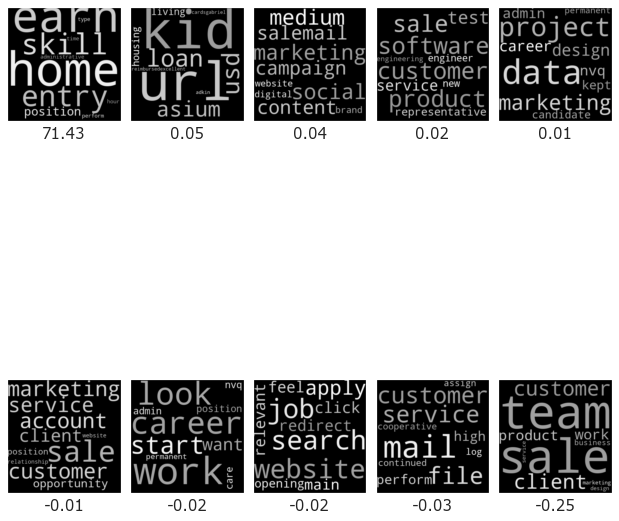

In [112]:
plot_topic_wordcloud(results_dict_new.get('loading'), total_variable[72:], num_topics=10, num_keywords_in_topic=10, save_name=None, grid_shape = [2,5])

# With Covariate

In [6]:
###### LR ######

results_dict_list = []

clf = LogisticRegression(random_state=0).fit(X_train.T, Y_train[0,:])
P_train = clf.predict_proba(X_train.T)
P_pred = clf.predict_proba(X_test.T)
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)

results.update({'method': 'LR'})
results.update({'xi': None})
results.update({'beta': None})
results.update({'Relative_reconstruction_loss (test)': 1})
results.update({'Accuracy': results.get('Accuracy')})
results_dict_list.append(results.copy())

mybeta = clf.coef_
result = pd.DataFrame({"word" : total_variable, "coef": mybeta[0]})
result1 = result.sort_values(by = 'coef', ascending = False).head(20)
result0 = result.sort_values(by = 'coef', ascending = False).tail(20)
result = pd.concat([result1, result0])
result

plt.rcParams['font.sans-serif'] = ['Verdana']

fig, ax = plt.subplots(1,1,figsize=(8,8))
result.plot.barh(ax = ax, x = 'word', y = 'coef', legend = None)
ax.set_title("Logistic Regression - Top 10 Variables with Largest Coefficients")
plt.show()
#plt.savefig("Output_files/Logistic/bargraph of top 10 beta coefficients - " + covariate + "_" + str(i) + ".pdf", bbox_inches='tight')

threshold from training set used: 0.11265808892075124
AUC ===> 0.976
Opt_threshold ===> 0.113
Accuracy ===> 0.942
Sensitivity ===> 0.778
Specificity ===> 0.950
Precision ===> 0.407
F_score ===> 0.535


C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# MF -> LR
r = 25
iteration = 200

W, H = ALS(text_train,
           n_components = r, # number of columns in the dictionary matrix W
           n_iter=iteration,
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=False,
           subsample_ratio = 1)

new_train = np.vstack((covariate_train, W.T @ text_train)).T
new_test = np.vstack((covariate_test, W.T @ text_test)).T

clf = LogisticRegression(random_state=0).fit(new_train, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:41<00:00,  2.31s/it]
C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


threshold from training set used: 0.051023143233831426
AUC ===> 0.907
Opt_threshold ===> 0.051
Accuracy ===> 0.818
Sensitivity ===> 0.810
Specificity ===> 0.818
Precision ===> 0.166
F_score ===> 0.276


In [ ]:
# MF -> LR
W, H = ALS(text_train,
           n_components = r, # number of columns in the dictionary matrix W
           n_iter=iteration,
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=False,
           subsample_ratio = 1)

new_train = np.vstack((covariate_train, W.T @ text_train)).T
new_test = np.vstack((covariate_test, W.T @ text_test)).T

clf = LogisticRegression(random_state=0).fit(new_train, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W.T, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

W0 = [W, clf.coef_]
plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [128]:
### NMF
print("nmf -> LR")
nmf = NMF(n_components = 25, random_state=1, alpha=0, l1_ratio=0).fit(text_train.T)
W = nmf.components_
H_train = nmf.fit_transform(text_train.T)
H_test = nmf.fit_transform(text_test.T, W = W)        

new_train = np.hstack((covariate_train.T, H_train))
new_test = np.hstack((covariate_test.T, H_test))

clf = LogisticRegression(random_state=0).fit(new_train, Y_train[0,:]) ## (W.T @ X_train).T -> H_train.T 
P_train = clf.predict_proba(new_train) ## (W.T @ X_train).T -> H_train.T
P_pred = clf.predict_proba(new_test) ## (W.T @ X_test).T -> H_test.T
results = compute_accuracy_metrics(Y_test[0], P_pred[:,1], train_data = [Y_train[0], P_train[:,1]], verbose=True)
results.update({'method': 'MF-LR'})

coder = SparseCoder(dictionary=W, transform_n_nonzero_coefs=None,
                                transform_alpha=0, transform_algorithm='lasso_lars', positive_code=True)
H1 = coder.transform(text_test.T).T
error_data = np.linalg.norm((text_test - W @ H1).reshape(-1, 1), ord=2)**2
rel_error_data = error_data / np.linalg.norm(text_test.reshape(-1, 1), ord=2)**2
results.update({'Relative_reconstruction_loss (test)': rel_error_data})
results.update({'xi': None})
results.update({'beta': None})
results.update({'W': W})
results.update({'betacoef': clf.coef_})
results_dict_list.append(results.copy())

threshold from training set used: 0.047842206028086816
AUC ===> 0.884
Opt_threshold ===> 0.048
Accuracy ===> 0.770
Sensitivity ===> 0.745
Specificity ===> 0.771
Precision ===> 0.127
F_score ===> 0.217


C:\Users\ljw95\.conda\envs\jleeenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [136]:
mybeta = clf.coef_
dic_list = []
for i in np.arange(25):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": mybeta[0][1:26]})
result
#idx2word = data.keys()
#fig_path = "Output_files/NMF/Wordcloud - " + covariate + "_" + str(i) + ".pdf"

plot_topic_wordcloud_nmf(result, W, total_variable[72:], num_topics=25, 
                         num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

word      coef
0    Topic1 -2.265651
1    Topic2 -0.202300
2    Topic3  0.393679
3    Topic4 -0.832529
4    Topic5  0.436534
5    Topic6 -0.280365
6    Topic7 -0.150995
7    Topic8  0.419902
8    Topic9  0.652758
9   Topic10  0.455621
10  Topic11 -1.099237
11  Topic12 -0.652917
12  Topic13  0.281917
13  Topic14 -0.078193
14  Topic15  0.152144
15  Topic16 -0.256898
16  Topic17 -0.016351
17  Topic18  0.498495
18  Topic19  0.069487
19  Topic20 -0.410768
20  Topic21 -0.800343
21  Topic22  1.341403
22  Topic23 -0.053682
23  Topic24  0.405450
24  Topic25  0.636080

In [42]:
# SDL - filter

iteration = 50
beta_list = [0.5]

for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            SNMF_class_new = SNMF(X=[text_train, Y_train],  # data, label
                            X_test=[text_test, Y_test],
                            X_auxiliary = covariate_train,
                            X_test_aux = covariate_test,      
                            n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                            # ini_loading=None,  # Initialization for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            # ini_code = H_true,
                            xi=xi,  # weight on label reconstruction error
                            L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                            L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                            nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                            full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

            results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                    beta = beta,
                                                    search_radius_const=np.linalg.norm(X_train),
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)
            results_dict_new.update({'method': 'SDL-filt'})
            results_dict_new.update({'beta': beta})
            results_dict_list.append(results_dict_new.copy())
            # print('Beta_learned', results_dict.get('loading')[1])

  0%|          | 0/50 [00:00<?, ?it/s]

initial loading beta [[ 0.78899726 -0.21927771  0.57462963 -0.20399697  0.14996344  0.41915778
   0.28519175 -0.29993227 -0.59711534 -0.45194748 -0.37179648  0.68101157
   0.08511778  0.97755343  0.19147997  0.49775329 -0.90903673 -0.47088552
   0.98730787 -0.20191228  0.41362453  0.36004638  0.19418662  0.72230499
  -0.77306266  0.36724822 -0.0025224  -0.1501003  -0.63140153  0.42395997
   0.46320447 -0.21899214 -0.59813159  0.54581643  0.53131653 -0.98837985
  -0.85139076 -0.43083616  0.06534111  0.1584814  -0.6588818   0.24342263
  -0.56131798  0.36955679 -0.46354523  0.58095931 -0.65031131  0.22187044
  -0.20981929  0.13552165  0.34602414  0.21221731  0.45838133 -0.03044882
  -0.58300886  0.58291402 -0.16966431 -0.0255624   0.25295071  0.93264644
  -0.08367135 -0.7346134  -0.4289387  -0.64050328 -0.25331568  0.34757035
   0.49905077 -0.15691595  0.37959644 -0.38055737  0.55020964 -0.15047824
  -0.98276301  0.44730466 -0.87644686  0.97622548  0.56013962  0.32450052
  -0.74204937  0.

/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  2%|▏         | 1/50 [00:01<01:24,  1.73s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

 30%|███       | 15/50 [00:21<00:47,  1.35s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 32%|███▏      | 16/50 [00:22<00:45,  1.34s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

 58%|█████▊    | 29/50 [00:41<00:32,  1.54s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 60%|██████    | 30/50 [00:42<00:30,  1.53s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

 86%|████████▌ | 43/50 [01:03<00:11,  1.63s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 88%|████████▊ | 44/50 [01:05<00:09,  1.59s/it]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

In [70]:
# SDL - feature

iteration = 200


prediction_method_list = ['naive']
for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            print("SDL-feat..")
            LMF_class_new = LMF(X=[X_train, Y_train],  # data, label
                            X_test=[X_test, Y_test],
                            X_auxiliary = covariate_train,
                            X_test_aux = covariate_test,      
                            n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                            # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            # ini_code = H_true,
                            xi=xi,  # weight on label reconstruction error
                            L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                            L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                            nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                            full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

            results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                    beta = beta,
                                                    search_radius_const=iteration*np.linalg.norm(X_train),
                                                    fine_tune_beta=True,
                                                    update_nuance_param=False,
                                                    prediction_method_list = prediction_method_list,
                                                    if_compute_recons_error=True, if_validate=False)

            for pred_type in prediction_method_list:
                results_dict_new.update({'method': 'SDL-feat ({})'.format(str(pred_type))})
                results_dict_new.update({'beta': beta})
                results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy ({})'.format(str(pred_type)))})
                results_dict_new.update({'F_score': results_dict_new.get('F_score ({})'.format(str(pred_type)))})
                results_dict_new.update({'time_error': results_dict_new.get('time_error')})
                results_dict_list.append(results_dict_new.copy())


  0%|          | 0/200 [00:00<?, ?it/s]

SDL-feat..
initial loading beta [[8.05722859e-01 7.11834783e-02 5.38864046e-01 8.57149692e-01
  2.00617277e-01 5.20206090e-01 5.04300049e-01 2.04682121e-01
  7.84481068e-01 9.93862709e-01 1.66756298e-01 7.77190078e-01
  4.99168069e-01 5.65056272e-01 4.17847155e-01 9.80346617e-01
  3.82481211e-01 4.91551905e-01 1.02005963e-01 3.62343859e-01
  3.92083179e-01 4.05391431e-01 5.07037442e-01 4.13435541e-01
  1.71201735e-01 2.65200961e-01 4.53359840e-01 3.49810427e-01
  3.37838501e-01 1.54843358e-01 3.06368235e-01 8.39670852e-01
  4.73562624e-02 4.53410152e-01 1.04054964e-01 1.43957031e-01
  5.35392827e-01 1.75123245e-01 4.59469995e-01 6.75147672e-01
  9.25935545e-01 8.01499340e-01 8.80113135e-01 1.43145215e-01
  1.55528272e-01 5.67587255e-01 6.14159652e-01 6.05892979e-02
  9.70510687e-01 5.63104613e-01 7.93547078e-01 2.95476153e-01
  6.91867150e-04 8.48717776e-01 9.34174067e-01 9.14497003e-01
  3.54538161e-01 8.57692199e-01 2.69769500e-01 5.30182621e-01
  4.33800259e-01 8.77899976e-01 5.5465

/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  0%|          | 1/200 [00:00<02:38,  1.26it/s]

--- Training --- [threshold, AUC] =  [0.039, 0.88]
--- Iteration 0: Training loss --- [Data, Label, Total] = [17776.762518.3, 2024.797465.3, 19801.559983.3]


/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  1%|          | 2/200 [00:01<02:20,  1.41it/s]/Users/hanbaeklyu/opt/anaconda3/envs/colourgraphenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation fo

--- Training --- [threshold, AUC] =  [0.96, 1.0]
--- Iteration 20: Training loss --- [Data, Label, Total] = [14461.835856.3, 27.448165.3, 14489.284021.3]


 20%|██        | 41/200 [00:12<00:55,  2.86it/s]

--- Training --- [threshold, AUC] =  [0.979, 1.0]
--- Iteration 40: Training loss --- [Data, Label, Total] = [13796.196169.3, 19.297942.3, 13815.494110.3]


 30%|███       | 61/200 [00:18<00:47,  2.93it/s]

--- Training --- [threshold, AUC] =  [0.981, 1.0]
--- Iteration 60: Training loss --- [Data, Label, Total] = [13518.492660.3, 15.749982.3, 13534.242642.3]


 40%|████      | 81/200 [00:23<00:41,  2.88it/s]

--- Training --- [threshold, AUC] =  [0.985, 1.0]
--- Iteration 80: Training loss --- [Data, Label, Total] = [13422.665957.3, 13.629451.3, 13436.295407.3]


 50%|█████     | 101/200 [00:28<00:36,  2.71it/s]

--- Training --- [threshold, AUC] =  [0.988, 1.0]
--- Iteration 100: Training loss --- [Data, Label, Total] = [13381.954725.3, 12.170926.3, 13394.125651.3]


 60%|██████    | 121/200 [00:34<00:29,  2.67it/s]

--- Training --- [threshold, AUC] =  [0.989, 1.0]
--- Iteration 120: Training loss --- [Data, Label, Total] = [13358.403490.3, 11.108368.3, 13369.511858.3]


 70%|███████   | 141/200 [00:40<00:20,  2.89it/s]

--- Training --- [threshold, AUC] =  [0.99, 1.0]
--- Iteration 140: Training loss --- [Data, Label, Total] = [13340.412926.3, 10.278427.3, 13350.691353.3]


 80%|████████  | 161/200 [00:45<00:14,  2.77it/s]

--- Training --- [threshold, AUC] =  [0.991, 1.0]
--- Iteration 160: Training loss --- [Data, Label, Total] = [13324.441271.3, 9.603413.3, 13334.044684.3]


 90%|█████████ | 181/200 [00:51<00:06,  2.74it/s]

--- Training --- [threshold, AUC] =  [0.991, 1.0]
--- Iteration 180: Training loss --- [Data, Label, Total] = [13309.018819.3, 9.046850.3, 13318.065669.3]


100%|██████████| 200/200 [00:56<00:00,  3.57it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.401, 0.878, 0.813, 0.272]


In [71]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 25,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.28315930e-06, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.85449652e-03],
         [7.72061736e-03, 1.57074419e-03, 9.77688966e-04, ...,
          0.00000000e+00, 0.00000000e+00, 3.46447415e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  array([[-1.18628201e+01,  1.95515722e-01,  2.24495285e+00,
           2.83497051e+00,  1.71476562e+00,  1.66951115e-01,
     

In [72]:
W0 = results_dict_new.get('loading')
# plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])
W0[1].shape

dic_list = []
for i in np.arange(25):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list += total_variable[0:72]
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": W0[1][0][1:]})
result1 = result.sort_values(by = 'coef', ascending = False).head(10)
result0 = result.sort_values(by = 'coef', ascending = False).tail(10)
result = pd.concat([result1, result0])
print(result)

(1, 98)

In [73]:
dic_list = []
for i in np.arange(25):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list += total_variable[0:72]
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": W0[1][0][1:]})
result1 = result.sort_values(by = 'coef', ascending = False).head(10)
result0 = result.sort_values(by = 'coef', ascending = False).tail(10)
result = pd.concat([result1, result0])
print(result)

                word      coef
2             Topic3  2.834971
19           Topic20  2.302796
1             Topic2  2.244953
11           Topic12  2.211231
17           Topic18  2.093546
3             Topic4  1.714766
21           Topic22  1.610779
23           Topic24  1.567431
10           Topic11  1.526550
20           Topic21  0.752240
9            Topic10 -0.514942
29    country_Non.US -0.627772
14           Topic15 -0.675526
6             Topic7 -0.935639
22           Topic23 -0.938074
15           Topic16 -1.248855
7             Topic8 -1.257063
16           Topic17 -1.360388
5             Topic6 -1.563330
26  has_company_logo -1.819969


!! Y work position home hour time entry able skill assistant service
!! Y home time day care position duty hour work week perform
!! Y position work require data skill experience free time hour home
!! Y standard test need quality administrative hr data desire engineer answer
!! Y skill control time maintenance engineering service require schedule include phone
!! Y work data want information process email start need week field
!! Y position candidate mail time high general data work perform information
!! Y url job provide month apply contract love cost student paid
!! Y home day time service seek position include hire person assist
!! Y look person provide work experience service patient international require position
!! Y work look community career driver start operation time procedure knowledge
!! Y application candidate responsible server performance site level production framework know
!! Y team customer work product business design new client sale marketing
!! Y year require exp

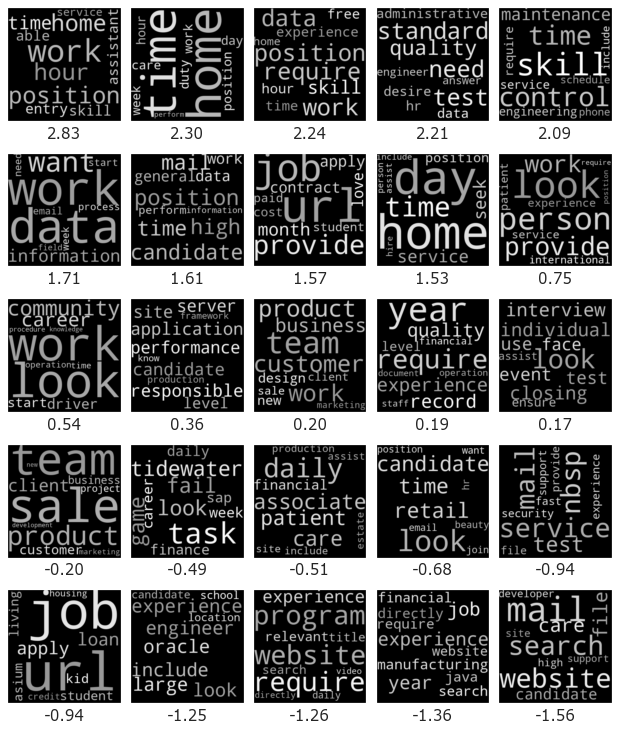

In [74]:
plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [77]:
# SDL_SVP_filter

xi_list = [1]
iter_avg = 1
data_scale = 1
iteration = 200
r = 25

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SDL_SVP_class = SDL_SVP(X=[text_train/data_scale, Y_train],  # data, label
                                X_test=[text_test/data_scale, Y_test],
                                X_auxiliary = covariate_train/data_scale,
                                X_test_aux = covariate_test/data_scale,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

        results_dict_new = SDL_SVP_class.fit(iter=iteration, subsample_size=None,
                                                beta = 0,
                                                nu = 2,
                                                search_radius_const=0.05,
                                                update_nuance_param=False,
                                                SDL_option = 'filter',
                                                prediction_method_list = ['filter'],
                                                fine_tune_beta = False,
                                                if_compute_recons_error=True, if_validate=False)
        results_dict_new.update({'method': 'SDL-conv-filt'})
        results_dict_new.update({'beta': None})
        results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (filter)')})
        results_dict_new.update({'F_score': results_dict_new.get('F_score (filter)')})
        #results_dict_list.append(results_dict_new.copy())

  0%|          | 0/200 [00:00<?, ?it/s]

initial loading beta [[ 0.31083033 -0.85590991 -0.81414484  0.03713994  0.39115335  0.7655725
  -0.18371166 -0.41267542  0.34767925 -0.7652234   0.49243213 -0.40692507
   0.37576517 -0.38451165  0.70266437  0.97147393  0.92365716  0.68205241
  -0.16082369  0.44650838  0.92310021 -0.6530487   0.04349429  0.24841393
   0.89015835  0.39323245 -0.45306314 -0.59796603 -0.04307301  0.01773605
   0.95168119  0.3199131   0.57136172  0.09052496  0.70610418 -0.87722975
   0.17039765  0.33416583 -0.37146546  0.31022949 -0.78523511 -0.92940365
  -0.20584197 -0.34865902 -0.77887925 -0.41062626  0.5838873   0.69851136
   0.57497234 -0.86730926 -0.48189843 -0.50526598 -0.77468798 -0.3298817
   0.107555   -0.4488901  -0.70564445  0.06302577  0.19815155 -0.29924207
  -0.72419461 -0.38061009 -0.78033412 -0.7905625   0.79438373 -0.89735896
  -0.55632482  0.52704968 -0.49022928  0.14052766  0.28775171  0.50349252
   0.19392943  0.34212341 -0.76069328  0.80016221  0.60263249  0.52315687
   0.26233683  0.34

/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:316: RuntimeWarning: overflow encountered in exp
  P_pred = 1 / (np.exp(-P_pred) + 1)
  0%|          | 1/200 [00:03<11:33,  3.48s/it]

*** rel_error_data train 82447.41911626955
--- Training --- [threshold, AUC] =  [1.0, 0.5]
--- Iteration 0: Training loss --- [Data, Label, Total] = [1174307691.346220.3, 1511402.557789.3, 1175819093.904009.3]
error_time (1, 3)


/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  1%|          | 2/200 [00:04<09:16,  2.81s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  2%|▏         | 3/200 [00:05<07:35,  2.31s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  2%|▏         | 4/200 [00:07<06:25,  1.97s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  2%|▎         | 5/200 [00:08<05:35,  1.72s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  3%|▎         | 6/200 [00:09<05:00,  1.55s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeW

*** rel_error_data train 10024.50311069065
--- Training --- [threshold, AUC] =  [0.0, 0.578]
--- Iteration 10: Training loss --- [Data, Label, Total] = [142780104.349988.3, 695364.854960.3, 143475469.204947.3]
error_time (2, 3)


/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  6%|▌         | 12/200 [00:17<04:47,  1.53s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  6%|▋         | 13/200 [00:19<04:27,  1.43s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  7%|▋         | 14/200 [00:20<04:12,  1.36s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  8%|▊         | 15/200 [00:21<04:02,  1.31s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
  8%|▊         | 16/200 [00:22<03:55,  1.28s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: Run

*** rel_error_data train 1219.5661340993288
--- Training --- [threshold, AUC] =  [0.0, 0.828]
--- Iteration 20: Training loss --- [Data, Label, Total] = [17370415.068525.3, 150444.954521.3, 17520860.023046.3]
error_time (3, 3)


/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 11%|█         | 22/200 [00:31<04:42,  1.59s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 12%|█▏        | 23/200 [00:32<04:22,  1.48s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 12%|█▏        | 24/200 [00:34<04:09,  1.42s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 12%|█▎        | 25/200 [00:35<04:00,  1.37s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 13%|█▎        | 26/200 [00:36<03:53,  1.34s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: Run

*** rel_error_data train 149.09010931149032
--- Training --- [threshold, AUC] =  [0.0, 0.846]
--- Iteration 30: Training loss --- [Data, Label, Total] = [2123506.884081.3, 101678.283911.3, 2225185.167992.3]
error_time (4, 3)


 20%|██        | 41/200 [01:00<05:14,  1.98s/it]

*** rel_error_data train 18.925350288583058
--- Training --- [threshold, AUC] =  [0.0, 0.865]
--- Iteration 40: Training loss --- [Data, Label, Total] = [269555.853216.3, 45976.864448.3, 315532.717664.3]
error_time (5, 3)


 26%|██▌       | 51/200 [01:15<04:46,  1.92s/it]

*** rel_error_data train 3.037242019312917
--- Training --- [threshold, AUC] =  [0.0, 0.845]
--- Iteration 50: Training loss --- [Data, Label, Total] = [43259.773344.3, 131122.300082.3, 174382.073426.3]
error_time (6, 3)


 30%|███       | 61/200 [01:31<04:28,  1.93s/it]

*** rel_error_data train 1.0663121197249599
--- Training --- [threshold, AUC] =  [0.0, 0.877]
--- Iteration 60: Training loss --- [Data, Label, Total] = [15187.601225.3, 53183.279002.3, 68370.880227.3]
error_time (7, 3)


 36%|███▌      | 71/200 [01:47<04:13,  1.97s/it]

*** rel_error_data train 0.8172664776085542
--- Training --- [threshold, AUC] =  [0.0, 0.893]
--- Iteration 70: Training loss --- [Data, Label, Total] = [11640.416654.3, 46073.968660.3, 57714.385314.3]
error_time (8, 3)


 40%|████      | 81/200 [02:03<03:55,  1.98s/it]

*** rel_error_data train 0.7839035510198054
--- Training --- [threshold, AUC] =  [0.0, 0.844]
--- Iteration 80: Training loss --- [Data, Label, Total] = [11165.224808.3, 114982.777573.3, 126148.002381.3]
error_time (9, 3)


 46%|████▌     | 91/200 [02:20<03:43,  2.05s/it]

*** rel_error_data train 0.7783960262756442
--- Training --- [threshold, AUC] =  [0.0, 0.906]
--- Iteration 90: Training loss --- [Data, Label, Total] = [11086.780525.3, 26070.824642.3, 37157.605166.3]
error_time (10, 3)


 50%|█████     | 101/200 [02:37<03:29,  2.12s/it]

*** rel_error_data train 0.7769366469818824
--- Training --- [threshold, AUC] =  [1.0, 0.901]
--- Iteration 100: Training loss --- [Data, Label, Total] = [11065.994424.3, 72432.324767.3, 83498.319191.3]
error_time (11, 3)


 51%|█████     | 102/200 [02:38<03:09,  1.93s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 56%|█████▌    | 111/200 [02:55<03:20,  2.25s/it]

*** rel_error_data train 0.7762728222940164
--- Training --- [threshold, AUC] =  [0.032, 0.926]
--- Iteration 110: Training loss --- [Data, Label, Total] = [11056.539496.3, 49433.567843.3, 60490.107339.3]
error_time (12, 3)


 60%|██████    | 121/200 [03:13<02:50,  2.16s/it]

*** rel_error_data train 0.775869028126144
--- Training --- [threshold, AUC] =  [0.002, 0.914]
--- Iteration 120: Training loss --- [Data, Label, Total] = [11050.788211.3, 26307.419620.3, 37358.207832.3]
error_time (13, 3)


 65%|██████▌   | 130/200 [03:27<01:55,  1.65s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:316: RuntimeWarning: overflow encountered in exp
  P_pred = 1 / (np.exp(-P_pred) + 1)
 66%|██████▌   | 131/200 [03:30<02:34,  2.24s/it]

*** rel_error_data train 0.7756222241240353
--- Training --- [threshold, AUC] =  [0.0, 0.603]
--- Iteration 130: Training loss --- [Data, Label, Total] = [11047.272954.3, 589013.610909.3, 600060.883863.3]
error_time (14, 3)


/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 66%|██████▌   | 132/200 [03:32<02:18,  2.04s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 66%|██████▋   | 133/200 [03:33<02:07,  1.90s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 67%|██████▋   | 134/200 [03:35<01:58,  1.79s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 68%|██████▊   | 135/200 [03:37<01:52,  1.74s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 70%|███████   | 141/200 [03:48<02:07,  2.16s/it]

*** rel_error_data train 0.7753918577374613
--- Training --- [threshold, AUC] =  [0.0, 0.912]
--- Iteration 140: Training loss --- [Data, Label, Total] = [11043.991821.3, 31642.529639.3, 42686.521460.3]
error_time (15, 3)


 76%|███████▌  | 151/200 [04:06<01:52,  2.30s/it]

*** rel_error_data train 0.7752647292658624
--- Training --- [threshold, AUC] =  [0.0, 0.832]
--- Iteration 150: Training loss --- [Data, Label, Total] = [11042.181116.3, 202307.858601.3, 213350.039717.3]
error_time (16, 3)


 80%|████████  | 161/200 [04:23<01:20,  2.06s/it]

*** rel_error_data train 0.7751395659948384
--- Training --- [threshold, AUC] =  [0.0, 0.95]
--- Iteration 160: Training loss --- [Data, Label, Total] = [11040.398401.3, 12276.485914.3, 23316.884316.3]
error_time (17, 3)


 84%|████████▍ | 169/200 [04:35<00:46,  1.51s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 86%|████████▌ | 171/200 [04:40<00:59,  2.04s/it]

*** rel_error_data train 0.7750484310826589
--- Training --- [threshold, AUC] =  [0.0, 0.869]
--- Iteration 170: Training loss --- [Data, Label, Total] = [11039.100357.3, 129368.967159.3, 140408.067516.3]
error_time (18, 3)


 90%|█████████ | 181/200 [04:56<00:38,  2.03s/it]

*** rel_error_data train 0.7749735568239007
--- Training --- [threshold, AUC] =  [0.0, 0.902]
--- Iteration 180: Training loss --- [Data, Label, Total] = [11038.033914.3, 97173.179262.3, 108211.213176.3]
error_time (19, 3)


 92%|█████████▏| 184/200 [05:01<00:26,  1.66s/it]/Users/hanbaeklyu/OneDrive/PycharmProjects/LMF/src/SDL_SVP.py:142: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-D))
 96%|█████████▌| 191/200 [05:13<00:18,  2.04s/it]

*** rel_error_data train 0.7748983730259721
--- Training --- [threshold, AUC] =  [0.0, 0.936]
--- Iteration 190: Training loss --- [Data, Label, Total] = [11036.963063.3, 41403.571596.3, 52440.534660.3]
error_time (20, 3)


100%|██████████| 200/200 [05:26<00:00,  1.63s/it]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.0, 0.94]
!!! ACC_list [0.8534675615212528]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.000, 0.908, 0.853, 0.879]


In [80]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'n_components': 25,
 'iter': 200,
 'dict_update_freq': 1,
 'Training_threshold': 8.608123928514349e-45,
 'Training_AUC': 0.9401072176404173,
 'Relative_reconstruction_loss (training)': 0.7748983730259721,
 'Classification_loss (training)': 41403.57159622498,
 'loading': [array([[ 3.25549992e-03,  2.01079497e-05, -2.42124730e-05, ...,
           3.66760226e-05, -5.30571536e-05, -3.00976237e-04],
         [ 3.81789089e-03,  6.33181479e-04, -1.46127547e-04, ...,
          -6.50079219e-05,  1.17788077e-03, -1.85217636e-04],
         [-1.75354570e-02,  1.00819498e-02, -1.60129139e-03, ...,
          -1.32718695e-03,  5.63599360e-03,  4.03921457e-03],
         ...,
         [ 9.12720044e-05,  5.69996443e-05, -4.28859017e-07, ...,
           9.29118193e-05,  1.00908500e-04, -2.21326137e-05],
         [ 2.24804117e-03,  4.94280519e-05,  5.78483969e-06, ...,
           1.88417327e-04,  1.66343045e-04,  1.49733454e-04],
         [ 6.06819892

(1, 98)
                                              word        coef
0                                           Topic1  528.768730
54  required_education_Some.High.School.Coursework   32.977686
60                         function_Administrative   31.191889
71                            function_Engineering   27.711721
59                    function_Accounting.Auditing   23.636086
47                required_education_Certification   23.551212
73                      function_Financial.Analyst   23.430305
72                                function_Finance   22.928836
76                        function_Human.Resources   19.789997
69                           function_Distribution   17.782649
37                   required_experience_Associate  -18.058999
89                      function_Quality.Assurance  -18.728633
85                             function_Production  -18.887561
51                      required_education_No.info  -19.400045
46            required_education_Bachelor.s.Deg

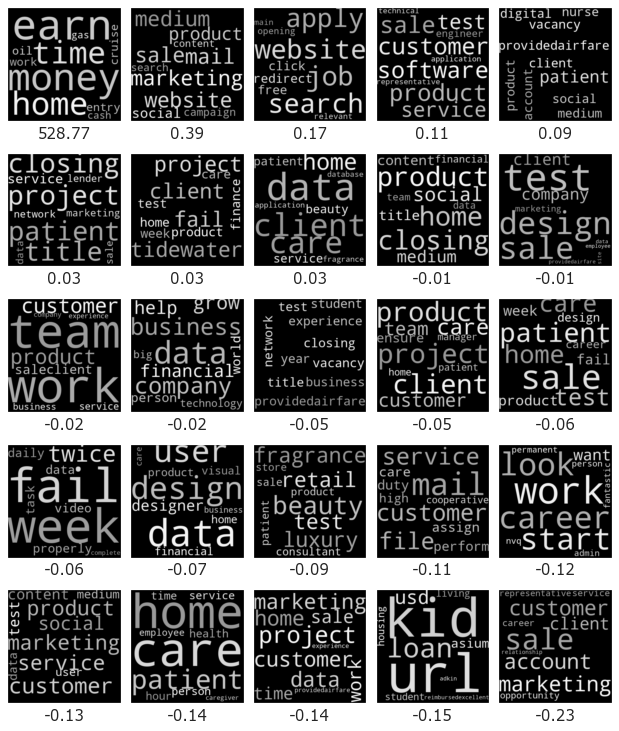

In [79]:
W0 = results_dict_new.get('loading')
# plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])
print(W0[1].shape)

dic_list = []
for i in np.arange(25):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list += total_variable[0:72]
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": W0[1][0][1:]})
result1 = result.sort_values(by = 'coef', ascending = False).head(10)
result0 = result.sort_values(by = 'coef', ascending = False).tail(10)
result = pd.concat([result1, result0])
print(result)

plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [81]:
# SDL_SVP_feature
data_scale=10
iteration = 50
prediction_method_list = ['naive']
for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        print("SDL-conv-feat..")
        data_scale=500
        SDL_SVP_class = SDL_SVP(X=[text_train/data_scale, Y_train],  # data, label
                                X_test=[text_test/data_scale, Y_test],
                                X_auxiliary = covariate_train/data_scale,
                                X_test_aux = covariate_test/data_scale,
                                n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                                # ini_code = H_true,
                                xi=xi,  # weight on label reconstruction error
                                L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                L2_reg = [0,0,0]) # L2 regularizer for code H, dictionary W[0], reg param W[1]


        results_dict_new = SDL_SVP_class.fit(iter=iteration, subsample_size=None,
                                            beta = 0,
                                            nu = 2,
                                            search_radius_const=0.01,
                                            update_nuance_param=False,
                                            SDL_option = 'feature',
                                            #prediction_method_list = ['naive', 'exhaustive'],
                                            prediction_method_list = prediction_method_list,
                                            if_compute_recons_error=True, if_validate=False)

        for pred_type in prediction_method_list:
            results_dict_new.update({'method': 'SDL-conv-feat ({})'.format(str(pred_type))})
            results_dict_new.update({'beta': None})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy ({})'.format(str(pred_type)))})
            results_dict_new.update({'F_score': results_dict_new.get('F_score ({})'.format(str(pred_type)))})
            results_dict_new.update({'time_error': results_dict_new.get('time_error')})
            results_dict_list.append(results_dict_new.copy())



SDL-conv-feat..


  0%|          | 0/50 [00:00<?, ?it/s]

initial loading beta [[ 3.59126419e-01 -8.84036660e-01 -5.78513833e-01 -3.59253547e-01
  -6.85826358e-01  5.16590607e-01 -4.81796255e-02  8.70222256e-01
  -3.80309837e-01 -1.28943424e-01 -2.40820364e-01 -4.49741831e-01
   8.03542427e-01 -2.65470942e-01  3.06684148e-01 -1.93301853e-01
  -3.81338795e-01 -6.38858519e-01  6.77917360e-01 -8.50985493e-01
  -4.50967688e-01  8.71287156e-01  3.75511498e-01  2.02981581e-01
   9.12059654e-01 -6.32858379e-01  3.00159977e-01 -5.78856066e-01
  -7.16410328e-02 -2.43693767e-01 -2.45555181e-01  3.46754730e-01
  -9.17200142e-01  4.53949219e-02  6.34314980e-01  2.66111025e-01
  -5.08219702e-01  8.41922530e-01 -1.81226254e-01 -2.33414424e-01
   7.38422865e-01 -4.06598258e-01  8.99074899e-01  7.54041655e-01
  -8.33252038e-01  9.43915605e-01 -8.62588684e-01 -2.34110767e-01
   1.64662582e-01  3.45636085e-01 -2.76157018e-01  8.00922303e-01
   9.82506613e-01 -2.56713350e-01  3.76785775e-02  8.61970258e-01
  -6.99161205e-01  2.03810595e-01 -6.05007530e-02  3.14

  2%|▏         | 1/50 [00:03<02:34,  3.16s/it]

*** rel_error_data train 24173421809.87473
--- Training --- [threshold, AUC] =  [0.0, 0.514]
--- Iteration 0: Training loss --- [Data, Label, Total] = [1377218860.784951.3, 36181.099635.3, 1377255041.884586.3]
error_time (1, 3)


 22%|██▏       | 11/50 [00:16<01:04,  1.64s/it]

*** rel_error_data train 16138369104.725592
--- Training --- [threshold, AUC] =  [0.0, 0.516]
--- Iteration 10: Training loss --- [Data, Label, Total] = [919442290.303228.3, 16544.479441.3, 919458834.782670.3]
error_time (2, 3)


 42%|████▏     | 21/50 [00:29<00:48,  1.68s/it]

*** rel_error_data train 10774103865.099611
--- Training --- [threshold, AUC] =  [0.0, 0.519]
--- Iteration 20: Training loss --- [Data, Label, Total] = [613827002.555751.3, 20445.256890.3, 613847447.812641.3]
error_time (3, 3)


 62%|██████▏   | 31/50 [00:42<00:31,  1.64s/it]

*** rel_error_data train 7192877628.262898
--- Training --- [threshold, AUC] =  [0.0, 0.522]
--- Iteration 30: Training loss --- [Data, Label, Total] = [409795800.150857.3, 13295.287008.3, 409809095.437865.3]
error_time (4, 3)


 82%|████████▏ | 41/50 [00:56<00:15,  1.72s/it]

*** rel_error_data train 4802022443.565347
--- Training --- [threshold, AUC] =  [0.0, 0.527]
--- Iteration 40: Training loss --- [Data, Label, Total] = [273582942.919950.3, 24400.262284.3, 273607343.182234.3]
error_time (5, 3)


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


!!! pred_type naive
--- Training --- [threshold, AUC] =  [0.0, 0.759]
!!! ACC_list [0.694910514541387]
--- Validation (naive) --- [threshold, AUC, accuracy, rel_error_data] = [0.000, 0.730, 0.695, 0.997]


(1, 98)
                                              word      coef
51                      required_education_No.info  0.975923
44              required_experience_Not.Applicable  0.943406
90                               function_Research  0.933951
72                                function_Finance  0.906576
41                  required_experience_Internship  0.890190
54  required_education_Some.High.School.Coursework  0.875632
85                             function_Production  0.859186
70                              function_Education  0.839302
36                       employment_type_Temporary  0.833447
50              required_education_Master.s.Degree  0.806821
55                  required_education_Unspecified -0.714208
43                     required_experience_No.info -0.805335
91                                  function_Sales -0.816365
84                     function_Product.Management -0.821088
74                       function_General.Business -0.833164
81              

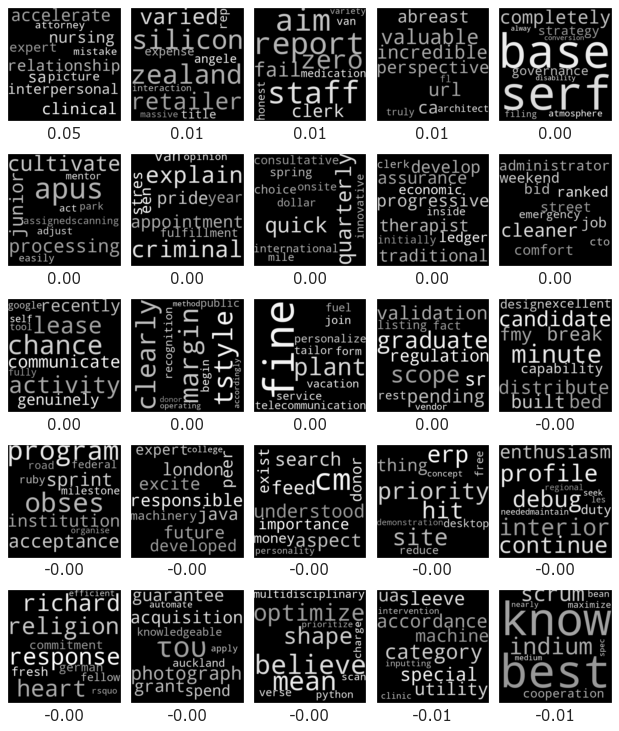

In [82]:
results_dict_new
W0 = results_dict_new.get('loading')
# plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])
print(W0[1].shape)

dic_list = []
for i in np.arange(25):
    i = i+1
    word = 'Topic' + str(i)
    dic_list.append(word)
dic_list += total_variable[0:72]
dic_list

result = pd.DataFrame({"word" : dic_list, "coef": W0[1][0][1:]})
result1 = result.sort_values(by = 'coef', ascending = False).head(10)
result0 = result.sort_values(by = 'coef', ascending = False).tail(10)
result = pd.concat([result1, result0])
print(result)

plot_topic_wordcloud(W0, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [58]:
H_ext = np.vstack((np.ones(text_test.shape[1]), H))
X0_ext = np.vstack((H_ext, covariate_test))
p_pred = np.matmul(W[1],X0_ext)
p_pred.shape

(1, 3576)

In [54]:
W[1].shape

(1, 98)

In [151]:
#os.chdir("Output_files\\FakeJob")
result_0 = np.load('results_SDL_sim7_fakejob.npy', allow_pickle=True)

In [208]:
method_0 = ["LR", "MF-LR", "SDL-filt", "SDL-feat (naive)", "SDL-conv-filt", "SDL-conv-feat (naive)"]
#xi_0 = [0, 0.1, 1, 5, 10]

method_0 = []
xi_0 = []
accuracy_0 = []
sensitivity_0 = []
specificity_0 = []
f_score_0 = []
reconstruct_0 = []

for idx in range(len(result_0)):
    
    if (result_0[idx].get('method') == "LR"):     
        method_0.append("Logistic Regression (LR)")
        xi_0.append(str("---"))
        accuracy_0.append(result_0[idx].get('Accuracy'))
        sensitivity_0.append(result_0[idx].get('Sensitivity'))
        specificity_0.append(result_0[idx].get('Specificity'))
        f_score_0.append(result_0[idx].get('F_score'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))     

"""
for idx in range(len(result_0)):

    if (result_0[idx].get('method') == "MF-LR"):     
        method_0.append("NMF - LR")
        xi_0.append(str("---"))
        accuracy_0.append(result_0[idx].get('Accuracy'))
        sensitivity_0.append(result_0[idx].get('Sensitivity'))
        specificity_0.append(result_0[idx].get('Specificity'))
        f_score_0.append(result_0[idx].get('F_score'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))     

for idx in range(len(result_0)):
        
    if (result_0[idx].get('method') == "SDL-filt"): 
        method_0.append("SDL - Filter")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy'))
        sensitivity_0.append(result_0[idx].get('Sensitivity'))
        specificity_0.append(result_0[idx].get('Specificity'))
        f_score_0.append(result_0[idx].get('F_score'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))       

for idx in range(len(result_0)):

    if (result_0[idx].get('method') == "SDL-feat (naive)"):     
        method_0.append("SDL - Feature")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy (naive)'))
        sensitivity_0.append(result_0[idx].get('Sensitivity (naive)'))
        specificity_0.append(result_0[idx].get('Specificity (naive)'))
        f_score_0.append(result_0[idx].get('F_score (naive)'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))

for idx in range(len(result_0)):
        
    if (result_0[idx].get('method') == "SDL-conv-filt"):
        method_0.append("SDL - Filter (Convex)")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy (filter)'))
        sensitivity_0.append(result_0[idx].get('Sensitivity (filter)'))
        specificity_0.append(result_0[idx].get('Specificity (filter)'))
        f_score_0.append(result_0[idx].get('F_score (filter)'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))

for idx in range(len(result_0)):

    if (result_0[idx].get('method') == "SDL-conv-feat (naive)"):     
        method_0.append("SDL - Feature (Convex)")
        xi_0.append(str(result_0[idx].get('xi')))
        accuracy_0.append(result_0[idx].get('Accuracy (naive)'))
        sensitivity_0.append(result_0[idx].get('Sensitivity (naive)'))
        specificity_0.append(result_0[idx].get('Specificity (naive)'))
        f_score_0.append(result_0[idx].get('F_score (naive)'))
        reconstruct_0.append(result_0[idx].get('Relative_reconstruction_loss (test)'))
"""        

'\nfor idx in range(len(result_0)):\n\n    if (result_0[idx].get(\'method\') == "MF-LR"):     \n        method_0.append("NMF - LR")\n        xi_0.append(str("---"))\n        accuracy_0.append(result_0[idx].get(\'Accuracy\'))\n        sensitivity_0.append(result_0[idx].get(\'Sensitivity\'))\n        specificity_0.append(result_0[idx].get(\'Specificity\'))\n        f_score_0.append(result_0[idx].get(\'F_score\'))\n        reconstruct_0.append(result_0[idx].get(\'Relative_reconstruction_loss (test)\'))     \n\nfor idx in range(len(result_0)):\n        \n    if (result_0[idx].get(\'method\') == "SDL-filt"): \n        method_0.append("SDL - Filter")\n        xi_0.append(str(result_0[idx].get(\'xi\')))\n        accuracy_0.append(result_0[idx].get(\'Accuracy\'))\n        sensitivity_0.append(result_0[idx].get(\'Sensitivity\'))\n        specificity_0.append(result_0[idx].get(\'Specificity\'))\n        f_score_0.append(result_0[idx].get(\'F_score\'))\n        reconstruct_0.append(result_0[idx].

In [211]:
method_0
accuracy_0

[0.913]

In [205]:
pd.set_option('display.max_rows', None)
result = pd.DataFrame(data=[accuracy_0,sensitivity_0,specificity_0,f_score_0,reconstruct_0]).T
result = result.set_axis(['Accuracy', 'Sensitivity', 'Specificity', 'F_score', 'Reconstruct_Error'], axis=1, inplace=False)
result.insert(0, column='xi', value= xi_0)
result.insert(0, column='Method', value= method_0)
result = round(result.groupby(['Method', 'xi'], sort=False).agg(['mean','std']),3)
result

Accuracy        Sensitivity        Specificity  \
                                  mean    std        mean    std        mean   
Method                   xi                                                    
Logistic Regression (LR) ---     0.913    NaN       0.784    NaN       0.919   
NMF - LR                 ---     0.697  0.049       0.745  0.019       0.695   
SDL - Filter             0.01    0.927  0.003       0.739  0.009       0.935   
                         0.1     0.927  0.001       0.725  0.000       0.936   
                         1       0.909  0.000       0.735  0.005       0.917   
                         5       0.894  0.000       0.706  0.009       0.903   
                         10      0.867  0.003       0.742  0.014       0.873   
SDL - Feature            0.01    0.844  0.005       0.739  0.009       0.849   
                         0.1     0.777  0.032       0.758  0.018       0.778   
                         1       0.849  0.021       0.712  0.046       0.855   
                         5       0.750  0.086       0.732  0.092       0.751   
                         10      0.715  0.045       0.722  0.005       0.715   
SDL - Filter (Convex)    0.01    0.578  0.140       0.526  0.226       0.580   
                         0.1     0.414  0.323       0.680  0.314       0.402   
                         1       0.730  0.062       0.647  0.083       0.734   
                         5       0.753  0.057       0.624  0.088       0.758   
                         10      0.686  0.161       0.650  0.189       0.688   
SDL - Feature (Convex)   0.01    0.201  0.006       0.850  0.000       0.171   
                         0.1     0.536  0.476       0.493  0.513       0.538   
                         1       0.957  0.000       0.000  0.000       1.000   
                         5       0.068  0.024       1.000  0.000       0.026   
                         10      0.081  0.037       1.000  0.000       0.040   

                                     F_score        Reconstruct_Error         
                                 std    mean    std              mean    std  
Method                   xi                                                   
Logistic Regression (LR) ---     NaN   0.436    NaN             1.000    NaN  
NMF - LR                 ---   0.051   0.176  0.027             0.810  0.006  
SDL - Filter             0.01  0.003   0.463  0.006             0.963  0.006  
                         0.1   0.001   0.460  0.003             0.884  0.003  
                         1     0.000   0.409  0.001             0.804  0.002  
                         5     0.001   0.364  0.003             0.786  0.000  
                         10    0.003   0.324  0.000             0.789  0.006  
SDL - Feature            0.01  0.004   0.289  0.009             0.957  0.005  
                         0.1   0.033   0.227  0.030             0.961  0.002  
                         1     0.024   0.289  0.015             0.934  0.001  
                         5     0.094   0.206  0.037             0.910  0.000  
                         10    0.047   0.180  0.022             0.898  0.000  
SDL - Filter (Convex)    0.01  0.156   0.095  0.009             0.989  0.000  
                         0.1   0.351   0.093  0.009             0.989  0.000  
                         1     0.068   0.172  0.015             0.989  0.000  
                         5     0.056   0.182  0.055             0.886  0.001  
                         10    0.159   0.172  0.111             0.888  0.006  
SDL - Feature (Convex)   0.01  0.006   0.083  0.001             0.997  0.000  
                         0.1   0.520   0.082  0.002             0.997  0.000  
                         1     0.000     NaN    NaN             0.997  0.000  
                         5     0.025   0.084  0.002             0.981  0.003  
                         10    0.038   0.085  0.003             0.978  0.000

!! Y work look start skill time mso learn person want company
!! Y client home data work time caregiver day person entry team
!! Y team test work software product person grow customer new look
!! Y customer service support require provide equipment include duty quality maintain
!! Y project development technical test software application experience requirement management engineering
!! Y team work experience software look developer environment join want skill
!! Y management accounting operation process financial hr office business maintain ensure
!! Y new intern use base help program high look excellent online
!! Y company tidewater finance position opportunity work employee time benefit hour
!! Y career admin kept nvq permanent start school work old fantastic
!! Y beauty fragrance retail luxury consultant store recruiting make fashion want
!! Y test campaign real engineer hotel software company work product manager
!! Y fail week twice shall properly daily task experience data securi

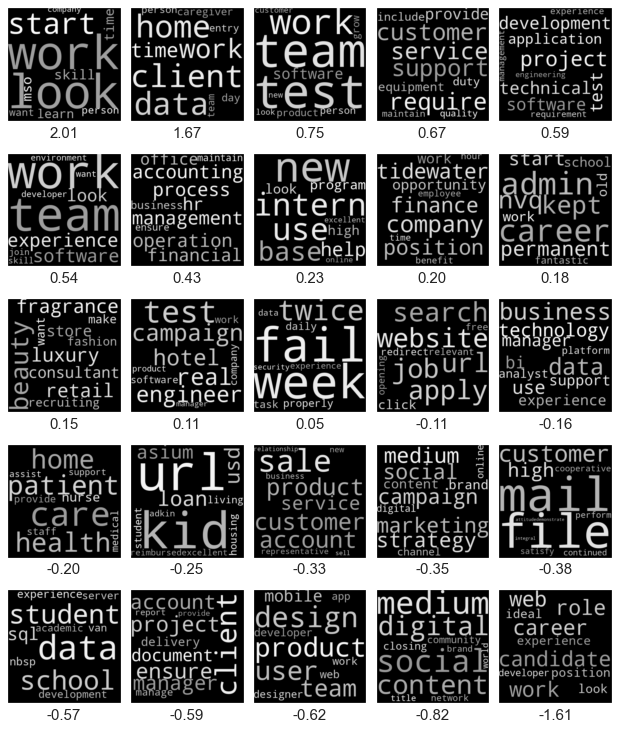

In [199]:
# NMF -> LR
W = result_0[1].get('W')
W2 = result_0[1].get('beta_regression')
W2 = np.asarray([list([1]) + list(W2[0])])
plot_topic_wordcloud([W,W2], total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

!! Y transparent athen deliverable unload machinery proactive award strong sigma je
!! Y disrupt realize erp proud form individual global asset google salary
!! Y pull expect edit emotional editor hansi printer detailparticipate guest fl
!! Y car investment impactful coordinate scan technician en personally necessary satisfy
!! Y london minimize inventory machine competitive citizen let hospital scrum priority
!! Y start original hire recent total extract outstanding worker acros cook
!! Y ambassador engine volunteer knowledge young broader partnership bay shape powerful
!! Y texa cs airfare career paypal deadline bit road recruit mindset
!! Y director involve indian behavimy initiative landscape st llc say equipmentshipping
!! Y immediate fulfill respond argentum marital partner indicator heavy soon category
!! Y mso festival abc approve offline meet curriculum lean photography attorney
!! Y solution formal university cruise bug houston nj heavily boundary contractual
!! Y specificati

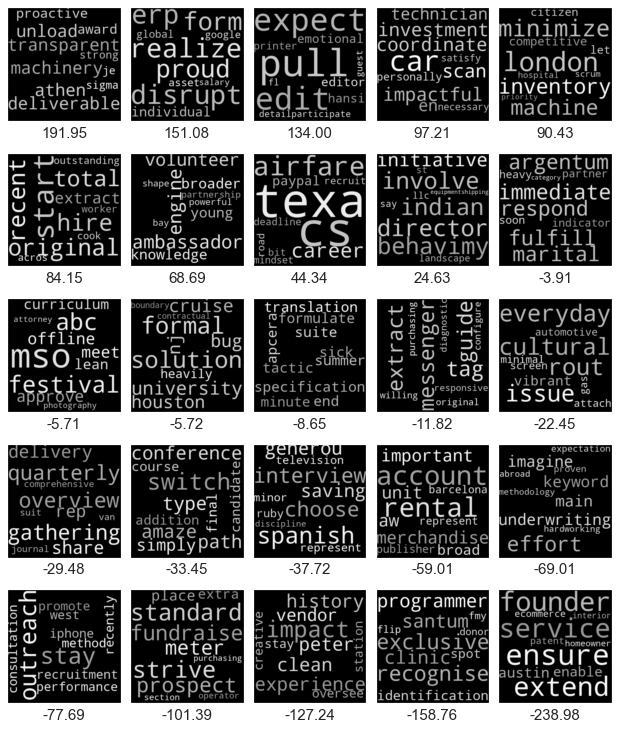

In [203]:
# Filter-based
W = result_0[6].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

!! Y conversation believe vice category format hard soon chief innovator perfect
!! Y photography dealer variety german design inbound placement telecommunication consideration suit
!! Y user daily week accuracy measure set disaster actionable fellow natural
!! Y indium του exchange standard manual date treatment outgo woman competitor
!! Y really upgrade developer concise climate flexibility stellar accountability angel public
!! Y st image version starter discussion conduct gt currency journey related
!! Y validate usability anticipate accounting twice similar fortune energetic officer onboarding
!! Y premier complete lead ipad step participant prototyping mobility calculation expansion
!! Y application transformation method teamwork firm unique apex pioneer indirect update
!! Y spent movement startup possible healthy prioritize visibility collateral use athen
!! Y park retailer ethical additionally cleaner authentic amazon raw reward package
!! Y advertiser retention quote able comp

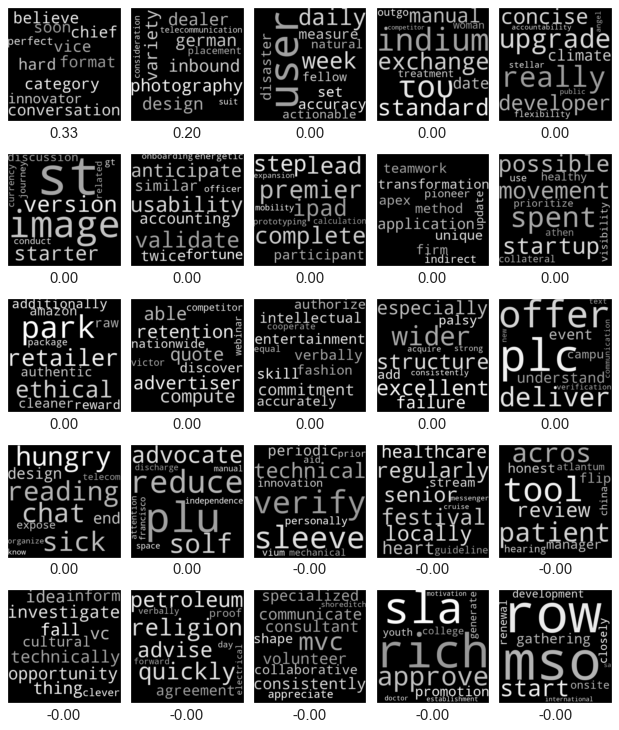

In [202]:
# Feature-based
W = result_0[18].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

!! Y earn money entry engineering administrative gas oil skill time link
!! Y office administrative support assistant event manager meeting manage email assist
!! Y customer service support need provide problem question representative issue request
!! Y project management team manager manage work development budget technical scope
!! Y test qa quality automate automation case assurance plan requirement functional
!! Y financial accounting account finance report include bank prepare monthly reconciliation
!! Y experience require title skill year ability knowledge closing candidate strong
!! Y fail week shall twice properly daily task video complete limited
!! Y care home patient caregiver health nurse personal medical provide person
!! Y product engineering market feature new team manager define launch development
!! Y tidewater position finance statu resume employment dealer salary disability collection
!! Y service employee provide closing professional network solution value hr traini

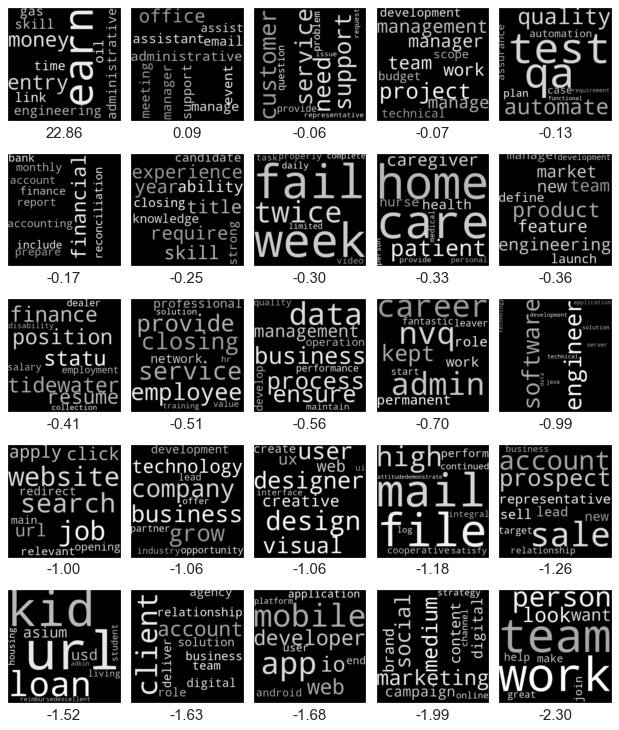

In [193]:
# Convex-Filter-based
W = result_0[40].get('loading')
plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])

In [212]:
# Convex-Feature-based

#W = result_0[28].get('loading')
#plot_topic_wordcloud(W, total_variable[72:], num_topics=25, num_keywords_in_topic=10, save_name=None, grid_shape = [5,5])
result_0[28]

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 25,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.99713645e-05, 0.00000000e+00, 0.00000000e+00],
         [5.60276650e-04, 5.67738105e-05, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.34446388e-03],
         [1.09088246e-02, 0.00000000e+00, 1.96319466e-03, ...,
          3.09970096e-03, 0.00000000e+00, 3.19436879e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 4.26297008e-07, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  array([[-6.49147453, -0.54384258,  0.01838749,  2.06831537, -1.77386246,
          -2.00198706, -1.41715918, -1.46732754,  0.

In [209]:
for i in range(len(result_0)):
    print(i, result_0[i].get('method'), result_0[i].get('xi'))

0 LR None
1 MF-LR None
2 MF-LR None
3 SDL-conv-filt 0.01
4 SDL-conv-filt 0.01
5 SDL-conv-filt 0.1
6 SDL-conv-filt 0.1
7 SDL-conv-filt 1
8 SDL-conv-filt 1
9 SDL-conv-filt 5
10 SDL-conv-filt 5
11 SDL-conv-filt 10
12 SDL-conv-filt 10
13 SDL-conv-feat (naive) 0.01
14 SDL-conv-feat (naive) 0.01
15 SDL-conv-feat (naive) 0.1
16 SDL-conv-feat (naive) 0.1
17 SDL-conv-feat (naive) 1
18 SDL-conv-feat (naive) 1
19 SDL-conv-feat (naive) 5
20 SDL-conv-feat (naive) 5
21 SDL-conv-feat (naive) 10
22 SDL-conv-feat (naive) 10
23 SDL-feat (naive) 0.01
24 SDL-feat (naive) 0.01
25 SDL-feat (naive) 0.1
26 SDL-feat (naive) 0.1
27 SDL-feat (naive) 1
28 SDL-feat (naive) 1
29 SDL-feat (naive) 5
30 SDL-feat (naive) 5
31 SDL-feat (naive) 10
32 SDL-feat (naive) 10
33 SDL-filt 0.01
34 SDL-filt 0.01
35 SDL-filt 0.1
36 SDL-filt 0.1
37 SDL-filt 1
38 SDL-filt 1
39 SDL-filt 5
40 SDL-filt 5
41 SDL-filt 10
42 SDL-filt 10
